# Clean Text Data

In [28]:
# # Check module locations if required
# import sys
# import pprint
# pprint.pprint(sys.path)

In [29]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs
import io
from lxml import etree
from dateutil.relativedelta import *

import seaborn as sns; sns.set(style="darkgrid")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [30]:
# Set display preference (Optional)
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 20
pd.options.display.max_seq_items = 50
pd.set_option('display.max_colwidth', 200)

## Define Utility Functions

In [84]:
# Functions for map() or apply()

def get_word_count(x):
    '''
    Retun the number of words for the given text x.
    '''
    x = x.replace("[SECTION]", "")
    return len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', x))
        
def get_rate_change(x):
    '''
    Returns rate change decision of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
    
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['RateDecision']
    else:        
        return None

def get_rate(x):
    '''
    Returns rate of the FOMC Decision for the given date x.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None
        
    if x in fomc_calendar.index:
        return fomc_calendar.loc[x]['Rate']
    else:        
        return None

def get_next_meeting_date(x):
    '''
    Returns the next fomc meeting date for the given date x, referring to fomc_calendar DataFrame.
    Usually FOMC Meetings takes two days, so it starts searching from x+2.
    x should be of datetime type or yyyy-mm-dd format string.
    '''
    # If x is string, convert to datetime
    if type(x) is str:
        try:
            x = dt.datetime.strptime(x, '%Y-%m-%d')
        except:
            return None

    # Add two days to get the day after next
    x = x + dt.timedelta(days=2)
    
    # Just in case, sort fomc_calendar from older to newer
    fomc_calendar.sort_index(ascending=True, inplace=True)
    
    if fomc_calendar.index[0] > x:
        # If the date is older than the first FOMC Meeting, do not return any date.
        return None
    else:
        for i in range(len(fomc_calendar)):
            if x < fomc_calendar.index[i]:
                return fomc_calendar.index[i]
        # If x is greater than the newest FOMC meeting date, do not return any date.
        return None
    
def get_chairperson(x):
    '''
    Return a string of chairperson's Fullname for the given date x.
    '''
    # If x is string, convert to datetime
    if isinstance(x, str):
        try:
            x = pd.to_datetime(x, format='%Y-%m-%d')
        except ValueError:
            return None
    
    chairperson = chairpersons[(chairpersons['FromDate'] <= x) & (x <= chairpersons['ToDate'])]
    if chairperson.empty:
        return None
    return list(chairperson.FirstName)[0] + " " + list(chairperson.Surname)[0]

In [32]:
def reorganize_df(df, doc_type):
    '''
    Reorganize the loaded dataframe, which has been obrained by FomcGetData for further processing
        - Add type
        - Add word count
        - Add rate, decision (for meeting documents, None for the others)
        - Add next meeting date, rate and decision
        - Copy contents to org_text
        - Remove line breaks from contents in text
        - Split contents by "[SECTION]" to list in text_sections
    '''
    
    if doc_type in ('statement', 'minutes', 'presconf_script', 'meeting_script'):
        is_meeting_doc = True
    elif doc_type in ('speech', 'testimony'):
        is_meeting_doc = False
    else:
        print("Invalid doc_type [{}] is given!".format(doc_type))
        return None
    
    dict = {
        'type': doc_type,
        'date': df['date'],
        'title': df['title'],
        'speaker': df['speaker'],
        'word_count': df['contents'].map(get_word_count),
        'decision': df['date'].map(lambda x: get_rate_change(x) if is_meeting_doc else None),
        'rate': df['date'].map(lambda x: get_rate(x) if is_meeting_doc else None),
        'next_meeting': df['date'].map(get_next_meeting_date),
        'next_decision': df['date'].map(get_next_meeting_date).map(get_rate_change),
        'next_rate': df['date'].map(get_next_meeting_date).map(get_rate),        
        'text': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip()),
        'text_sections': df['contents'].map(lambda x: x.replace('\n','').replace('\r','').strip().split("[SECTION]")),
        'org_text': df['contents']
    }

    new_df = pd.DataFrame(dict)
    new_df['decision'] = new_df['decision'].astype('Int8')
    new_df['next_decision'] = new_df['next_decision'].astype('Int8')
    print("No rate decision found: ", new_df['decision'].isnull().sum())
    print("Shape of the dataframe: ", new_df.shape)
    #new_df.dropna(subset=['decision'], axis=0, inplace=True)
    return new_df

In [33]:
# Split functions to process long text in machine learning based NLP

def get_split(text, split_len=200, overlap=50):
    '''
    Returns a list of split text of $split_len with overlapping of $overlap.
    Each item of the list will have around split_len length of text.
    '''
    l_total = []
    words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)
    
    if len(words) < split_len:
        n = 1
    else:
        n = (len(words) - overlap) // (split_len - overlap) + 1
        
    for i in range(n):
        l_parcial = words[(split_len - overlap) * i: (split_len - overlap) * i + split_len]
        l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=200, overlap=50):
    '''
    Returns a dataframe which is an extension of an input dataframe.
    Each row in the new dataframe has less than $split_len words in 'text'.
    '''
    split_data_list = []

    for i, row in tqdm(df.iterrows(), total=df.shape[0]):
        #print("Original Word Count: ", row['word_count'])
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            row['text'] = text
            #print(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text)))
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            split_data_list.append(list(row))
            
    split_df = pd.DataFrame(split_data_list, columns=df.columns)
    split_df['decision'] = split_df['decision'].astype('Int8')
    split_df['next_decision'] = split_df['next_decision'].astype('Int8')

    return split_df

In [34]:
def remove_short_section(df, min_words=50):
    '''
    Using 'text_sections' of the given dataframe, remove sections having less than min_words.
    It concatinate sections with a space, which exceeds min_words and update 'text'.
    As a fallback, keep a text which concatinates sections having more than 20 words and use it
     if there is no section having more than min_words.
    If there is no sections having more than 20 words, remove the row.
    '''
    new_df = df.copy()
    new_text_list = []
    new_text_section_list = []
    new_wc_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_text = ""
        bk_text = ""
        new_text_section = []
        bk_text_section = []
                
        for section in row['text_sections']:
            num_words = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section))
            if num_words > min_words:
                new_text += " " + section
                new_text_section.append(section)
            elif num_words > 20:
                bk_text += " " + section
                bk_text_section.append(section)
                
        
        new_text = new_text.strip()
        bk_text = bk_text.strip()
        
        if len(new_text) > 0:
            new_text_list.append(new_text)
            new_text_section_list.append(new_text_section)
        elif len(bk_text) > 0:
            new_text_list.append(bk_text)
            new_text_section_list.append(bk_text_section)
        else:
            new_text_list.append("")
            new_text_section_list.append("")
        
        # Update the word count
        new_wc_list.append(len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', new_text_list[-1])))
        
    new_df['text'] = new_text_list
    new_df['word_count'] = new_wc_list
    
    return new_df.loc[new_df['word_count'] > 0]

def remove_short_nokeyword(df, keywords = ['rate', 'rates', 'federal fund', 'outlook', 'forecast', 'employ', 'economy'], min_times=2, min_words=50):
    '''
    Drop sections which do not have any one of keywords for min_times times
     before applying remove_short_section()
    '''
    
    new_df = df.copy()
    new_section_list = []
    
    for i, row in tqdm(new_df.iterrows(), total=new_df.shape[0]):
        new_section = []
                
        for section in row['text_sections']:
            if len(set(section.split()).intersection(keywords)) >= min_times:
                new_section.append(section)
        
        new_section_list.append(new_section)
    
    new_df['text_sections'] = new_section_list
    
    return remove_short_section(new_df, min_words=min_words)

## Load Data

### Chairpersons

In [35]:
# FOMC Chairperson's list
chairpersons = pd.DataFrame(
    data=[["Volcker", "Paul", dt.datetime(1979,8,6), dt.datetime(1987,8,10)],
          ["Greenspan", "Alan", dt.datetime(1987,8,11), dt.datetime(2006,1,31)], 
          ["Bernanke", "Ben", dt.datetime(2006,2,1), dt.datetime(2014,1,31)], 
          ["Yellen", "Janet", dt.datetime(2014,2,3), dt.datetime(2018,2,3)],
          ["Powell", "Jerome", dt.datetime(2018,2,5), dt.datetime(2022,2,5)]],
    columns=["Surname", "FirstName", "FromDate", "ToDate"])
chairpersons

,Surname,FirstName,FromDate,ToDate
0,Volcker,Paul,1979-08-06,1987-08-10
1,Greenspan,Alan,1987-08-11,2006-01-31
2,Bernanke,Ben,2006-02-01,2014-01-31
3,Yellen,Janet,2014-02-03,2018-02-03
4,Powell,Jerome,2018-02-05,2022-02-05


### Load Calendar

In [36]:
file = open('../data/preprocessed/fomc_calendar.pickle', 'rb')

fomc_calendar = pickle.load(file)
file.close()

print(fomc_calendar.shape)
fomc_calendar

(405, 8)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged
date,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.50,-0.50,-1,1
1982-11-16,False,False,False,Paul Volcker,9.00,-0.50,-1,1
1982-12-21,False,False,False,Paul Volcker,8.50,0.00,0,0
1983-01-14,False,False,True,Paul Volcker,8.50,0.00,0,0
1983-01-21,False,False,True,Paul Volcker,8.50,0.00,0,0
...,...,...,...,...,...,...,...,...
2023-06-14,False,True,False,Jerome Powell,5.00,0.00,0,0
2023-07-26,False,False,False,Jerome Powell,5.25,0.25,1,1
2023-09-20,False,True,False,Jerome Powell,5.25,0.00,0,0


In [37]:
# #Check caleander
# fomc_calendar.loc[fomc_calendar.index >= dt.datetime(1998, 1, 27)]

### Statement

In [38]:
file = open('../data/FOMC/statement.pickle', 'rb')

statement_df = pickle.load(file)
file.close()

print(statement_df.shape)
statement_df

(202, 4)


,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
...,...,...,...,...
197,2023-06-14,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
198,2023-07-26,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
199,2023-09-20,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
200,2023-11-01,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement


In [39]:
# Sample Contents - the 2nd last
print(statement_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides
          the nation with a safe, flexible, and stable monetary and financial
          system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Financial Stability Assessments

[SECTION]

Financial Stability Coordination & Actions

[SECTION]

Reports

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers

### Meeting Minutes

In [40]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

print(minutes_df.shape)
minutes_df

(230, 4)


,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
...,...,...,...,...
225,2023-05-03,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Meeting Minutes
226,2023-06-14,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Meeting Minutes
227,2023-07-26,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Meeting Minutes
228,2023-09-20,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Meeting Minutes


In [41]:
# Sample Contents - the 2nd last
print(minutes_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides
          the nation with a safe, flexible, and stable monetary and financial
          system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Financial Stability Assessments

[SECTION]

Financial Stability Coordination & Actions

[SECTION]

Reports

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers

### Meeting Transcripts

In [42]:
file = open('../data/FOMC/meeting_script.pickle', 'rb')

meeting_script_df = pickle.load(file)
file.close()

print(meeting_script_df.shape)
meeting_script_df

(282, 4)


,date,contents,speaker,title
0,1980-01-09,MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...,other,FOMC Meeting Transcript
1,1980-02-05,CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on t...,other,FOMC Meeting Transcript
2,1980-03-18,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have ...",other,FOMC Meeting Transcript
3,1980-04-22,"CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to yo...",other,FOMC Meeting Transcript
4,1980-05-20,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\r\n\n[SECT...",other,FOMC Meeting Transcript
...,...,...,...,...
277,2014-06-18,"CHAIR YELLEN. I'd like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but both have ...",Janet Yellen,FOMC Meeting Transcript
278,2014-07-30,"CHAIR YELLEN. Good morning, everybody. I would like to begin today's meeting by giving the floor to President Fisher, who asked if he could take a minute to address the group.\r\n\n[SECTION]\n\nMR...",Janet Yellen,FOMC Meeting Transcript
279,2014-09-17,"CHAIR YELLEN. Good morning, everybody.\rOur first two items this morning will be conducted in a joint meeting between the FOMC\rand the Board. I need a motion to close the Board meeting.\r\n\n[SEC...",Janet Yellen,FOMC Meeting Transcript
280,2014-10-29,"CHAIR YELLEN. I'd like to call this meeting to order. Before turning to our agenda, I'd like to say a few words about our communications with the public. Many of you will recall that in June 2011,...",Janet Yellen,FOMC Meeting Transcript


In [43]:
# Sample Contents - the 2nd last
print(meeting_script_df['contents'].iloc[-1])

the Board meeting.to consider is in a joint Board and FOMC meeting, so I need a motion to close

[SECTION]

MR. FISCHER. So moved.

[SECTION]

Simon to give us his report on market developments.ng to start off by calling on

[SECTION]

Madam Chair, this completes my part of the Desk briefing. We would be happy to answer questions before moving on to Lorie's part.e discussion of this service in the October minutes generated considerable interest amongst Fed watchers. As you recall, SBAs are designed to improve competition in the deposit market. The mechanism through which they would improve competition is similar to, but different in important respects from, the use of RRPs. Many market participants interpreted the discussion in the minutes as suggesting SBAs would receive important regulatory relief which would substantially lower the balance sheet costs of attracting funds into such accounts. As you know, such relief was not part of the plan for the service, although some other types 

### Press Conference Transcripts

In [44]:
file = open('../data/FOMC/presconf_script.pickle', 'rb')

presconf_script_df = pickle.load(file)
file.close()

print(presconf_script_df.shape)
presconf_script_df

(60, 4)


,date,contents,speaker,title
0,2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec...",Ben Bernanke,FOMC Press Conference Transcript
1,2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I'll briefly review today's policy decision. And I'll place the decision in the context of our economic projections and ...",Ben Bernanke,FOMC Press Conference Transcript
2,2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today's policy decision of the Federal Open Market Committee, and I will place that decision in ...",Ben Bernanke,FOMC Press Conference Transcript
3,2012-01-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today's policy decision by the Federal Open Market Committee. And then I'll discuss next the consensus st...,Ben Bernanke,FOMC Press Conference Transcript
4,2012-04-25,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I'll summarize today's policy action by the Federal Open Market Committee and then I'll place the Committee's policy decision in the ...",Ben Bernanke,FOMC Press Conference Transcript
...,...,...,...,...
55,2023-06-14,CHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. We understand the hardship th...,other,FOMC Press Conference Transcript
56,2023-07-26,CHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. We understand the hardship th...,other,FOMC Press Conference Transcript
57,2023-09-20,"CHAIR POWELL. Good afternoon, everyone. My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. We understand the h...",other,FOMC Press Conference Transcript
58,2023-11-01,"CHAIR POWELL. Good afternoon, everyone. Welcome. My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. We underst...",other,FOMC Press Conference Transcript


In [45]:
# Sample Contents - the 2nd last
print(presconf_script_df['contents'].iloc[-1])

Transcript of Chair Powell's Press Conference December 13, 2023

[SECTION]

Chair Powell's Press Conferencegrowth of economic activity has slowed substantially from the outsized pace seen in the third quarter. Even so, GDP is on track to expand around 2-1/2hat we face, the Committee is proceeding carefully. We will make decisions about the extent of any additional policy firming and how long policy will remain restrictive based on the totality of the incoming data, the evolving outlook, and the balance of risks. I will have more to say about monetary policy after briefly reviewing economic developments.is uncertain. As we look ahead to next year, I want to assure the American people that we are fully committed to returning inflation to our 2 percent goal. Restoring price stability is essential to achieve a sustained period of strong labor market conditions that benefit all.

[SECTION]

Chair Powell's Press Conferencest year but remains above our longer-run goal of 2 percent. Based on t

### Speech

In [46]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

print(speech_df.shape)
speech_df

(1711, 4)


,date,contents,speaker,title
0,1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1,1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
2,1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
3,1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
4,1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
...,...,...,...,...
1706,2023-11-28,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Governor Michelle W. Bowman,Reflections on the Economy and Monetary Policy
1707,2023-11-28,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Vice Chair for Supervision Michael S. Barr,Serving Indian Country with the Modernized Community Reinvestment Act
1708,2023-12-01,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Vice Chair for Supervision Michael S. Barr,The Importance of Effective Liquidity Risk Management
1709,2023-12-01,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Chair Jerome H. Powell,Opening Remarks


In [47]:
# Sample Contents - the 2nd last
print(speech_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides
          the nation with a safe, flexible, and stable monetary and financial
          system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Financial Stability Assessments

[SECTION]

Financial Stability Coordination & Actions

[SECTION]

Reports

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers

### Testimony

In [48]:
file = open('../data/FOMC/testimony.pickle', 'rb')

testimony_df = pickle.load(file)
file.close()

print(testimony_df.shape)
testimony_df

(466, 4)


,date,contents,speaker,title
0,1996-06-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...,"Governor Edward W. Kelley, Jr.",Supervision of bank sales practices
1,1996-07-17,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder...","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation","""Prime bank"" schemes"
2,1996-07-18,"Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT...",Chairman Alan Greenspan,The Federal Reserve's semiannual monetary report
3,1996-07-24,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...,Governor Janet L. Yellen,Trends in consumer lending
4,1996-07-26,\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...,Chairman Alan Greenspan,Recent reports on Federal Reserve operations
...,...,...,...,...
461,2023-06-21,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Governor Lisa D. Cook,Nomination hearing
462,2023-06-21,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Chair Jerome H. Powell,Semiannual Monetary Policy Report to the Congress
463,2023-07-18,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...","Michael S. Gibson, Director of Supervision and Regulation",Climate-Related Financial Risks
464,2023-11-14,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",Vice Chair for Supervision Michael S. Barr,Supervision and Regulation


In [49]:
# Sample Contents - the 2nd last
print(testimony_df['contents'].iloc[-1])

The Federal Reserve, the central bank of the United States, provides
          the nation with a safe, flexible, and stable monetary and financial
          system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Financial Stability Assessments

[SECTION]

Financial Stability Coordination & Actions

[SECTION]

Reports

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers

## Statements DataFrame

In [50]:
statement_df.head()

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement


### Add Quantitative Easing as a Lower event

In [51]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.

if statement_df.loc[statement_df['date'] == dt.datetime.strptime('2008-11-25', '%Y-%m-%d')].shape[0] == 0:
    qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
              "to purchase the direct obligations of housing-related government-sponsored "\
              "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
              "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
              "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
              "have widened appreciably of late.  This action is being taken to reduce the cost "\
              "and increase the availability of credit for the purchase of houses, which in turn "\
              "should support housing markets and foster improved conditions in financial markets "\
              "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
              "the program will be conducted with the Federal Reserve's primary dealers through "\
              "a series of competitive auctions and will begin next week.  Purchases of up to "\
              "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
              "process with a goal of beginning these purchases before year-end.  "\
              "Purchases of both direct obligations and MBS are expected to take place over "\
              "several quarters.  Further information regarding the operational details of this "\
              "program will be provided after consultation with market participants."

        
    statement_df.loc[statement_df.index == dt.datetime(2008,11,25), ['contents', 'speaker', 'title']] = (qe_text, 'Ben Bernanke', 'FOMC statement') # QE1 anounced    

    
    

In [52]:
statement_df

,date,contents,speaker,title
0,1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,FOMC Statement
1,1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,FOMC Statement
2,1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,FOMC Statement
3,1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,FOMC Statement
4,1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,FOMC Statement
...,...,...,...,...
197,2023-06-14,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
198,2023-07-26,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
199,2023-09-20,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement
200,2023-11-01,"The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O...",other,FOMC Statement


### Process the dataframe

In [53]:
# Reorganize the dataframe
proc_statement_df = reorganize_df(statement_df, 'statement')

No rate decision found:  0
Shape of the dataframe:  (202, 13)


In [54]:
# Check the returned dataframe
proc_statement_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,160,1,4.25,1994-07-06,0,4.25,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,137,1,4.75,1994-09-27,0,4.75,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2023-06-14,FOMC Statement,other,511,0,5.00,2023-07-26,1,5.25,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Feder

In [55]:
# Check which row does not have rate
proc_statement_df.loc[proc_statement_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


In [56]:
x = dt.datetime.strptime('2019-01-01', '%Y-%m-%d')
fomc_calendar.loc[fomc_calendar.index > x]

,unscheduled,forecast,confcall,ChairPerson,Rate,RateDiff,RateDecision,RateChanged
date,,,,,,,,
2019-01-30,False,False,False,Jerome Powell,2.25,0.00,0,0
2019-03-20,False,True,False,Jerome Powell,2.25,0.00,0,0
2019-05-01,False,False,False,Jerome Powell,2.25,0.00,0,0
2019-06-19,False,True,False,Jerome Powell,2.25,0.00,0,0
2019-07-31,False,False,False,Jerome Powell,2.00,-0.25,-1,1
...,...,...,...,...,...,...,...,...
2023-06-14,False,True,False,Jerome Powell,5.00,0.00,0,0
2023-07-26,False,False,False,Jerome Powell,5.25,0.25,1,1
2023-09-20,False,True,False,Jerome Powell,5.25,0.00,0,0


In [57]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_statement_df = remove_short_section(proc_statement_df, min_words=50)
proc_statement_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,0,3.25,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.50,1994-04-18,1,3.75,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,1,4.25,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,0,4.25,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...","[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,0,4.75,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...","[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
197,statement,2023-06-14,FOMC Statement,other,223,0,5.00,2023-07-26,1,5.25,"The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. In support of these goals, the Committee decided to maintain the target range for the ...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and fina

c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

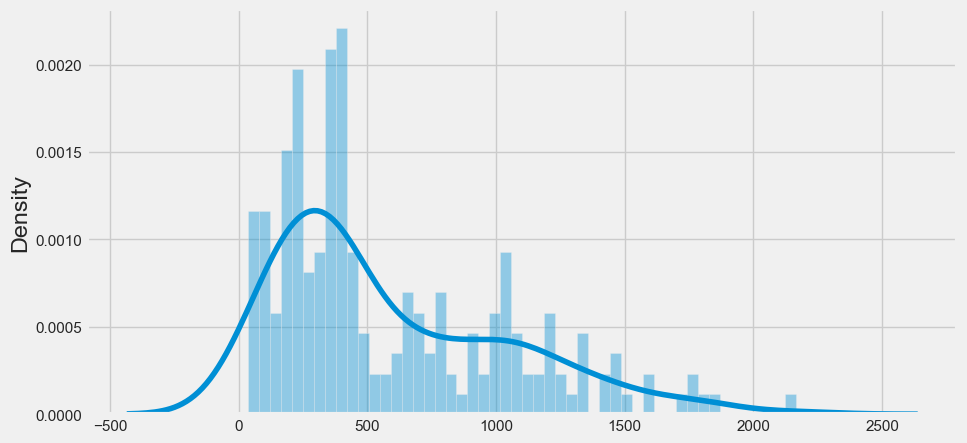

In [58]:
plt.figure(figsize=(10,5))
sns.distplot(proc_statement_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [59]:
split_statement_df = get_split_df(proc_statement_df)
split_statement_df.tail(10)

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
827,statement,2023-06-14,FOMC Statement,other,200,0,5.00,2023-07-26,1,5.25,The Committee seeks to achieve maximum employment and inflation at the rate of percent over the longer run In support of these goals the Committee decided to maintain the target range for the fede...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
828,statement,2023-06-14,FOMC Statement,other,73,0,5.00,2023-07-26,1,5.25,stance of monetary policy the Committee will continue to monitor the implications of incoming information for the economic outlook The Committee would be prepared to adjust the stance of monetary ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
829,statement,2023-07-26,FOMC Statement,other,200,1,5.25,2023-09-20,0,5.25,The Committee seeks to achieve maximum employment and inflation at the rate of percent over the longer run In support of these goals the Committee decided to raise the target range for the federal...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
830,statement,2023-07-26,FOMC Statement,other,66,1,5.25,2023-09-20,0,5.25,continue to monitor the implications of incoming information for the economic outlook The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that co...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
831,statement,2023-09-20,FOMC Statement,other,200,0,5.25,2023-11-01,0,5.25,The Committee seeks to achieve maximum employment and inflation at the rate of percent over the longer run In support of these goals the Committee decided to maintain the target range for the fede...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
832,statement,2023-09-20,FOMC Statement,other,66,0,5.25,2023-11-01,0,5.25,continue to monitor the implications of incoming information for the economic outlook The Committee would be prepared to adjust the stance of monetary policy as appropriate if risks emerge that co...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
833,statement,2023-11-01,FOMC 

### Filter out by keywords

In [60]:
# Keep sections having keywords and long enough
keyword_statement_df = remove_short_nokeyword(proc_statement_df)
keyword_statement_df.reset_index(drop=True, inplace=True)
print(keyword_statement_df.shape)
keyword_statement_df


(98, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,0,4.25,"The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sho...","[The Board approved an increase in the discount rate from 3 percent to 3-1/2 percent, effective immediately, and the Federal Open Market Committee agreed that this increase should be allowed to sh...",\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.50,1994-12-20,0,5.50,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.","[In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets.]","\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,403,-1,5.25,1996-03-26,0,5.25,"For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective im...","[For immediate releaseThe Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective i...",For immediate release\n\n\n\n\n\n\r\n\r\nThe Federal Reserve today announced the following policy \r\nactions:\r\n\r\n\nThe Board of Governors approved a reduction in the discount rate from \r\n5-...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,432,1,5.50,1997-05-20,0,5.50,"For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 pe...","[For immediate release\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage point to around 5-1/2 p...","For immediate release\n\n\n\n\n\n\r\n\r\n\tThe Federal Open Market Committee decided today to tighten money market conditions slightly, expecting the federal funds rate to rise 1/4 percentage poin..."
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,400,-1,5.25,1998-10-15,-1,5.00,"For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1/...","[For immediate releaseThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage point to around 5-1...","For immediate release\n\n\n\n\n\n\r\nThe Federal Open Market Committee decided today to ease the stance of monetary policy slightly, expecting the federal funds rate to decline 1/4 percentage poin..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,statement,2021-07-28,FOMC Statement,Jerome Powell,223,0,0.00,2021-09-22,0,0.00,"The Committee seeks to achieve maximum employment and inflation at the rate of 2 percent over the longer run. With inflation having run persistently below this longer-run goal, the Committee will ...","[The path of the economy continues to depend on the course of the virus. Progress on vaccinations will likely continue to reduce the effects of the public health crisis on the e

In [61]:
# Drop text during the process to reduce the output size
proc_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_statement_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Minutes DataFrame

In [62]:
minutes_df.head()

,date,contents,speaker,title
0,1993-02-03,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at...",Alan Greenspan,FOMC Meeting Minutes
1,1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,FOMC Meeting Minutes
2,1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes
3,1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,FOMC Meeting Minutes
4,1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,FOMC Meeting Minutes


In [63]:
# Reorganize the dataframe
proc_minutes_df = reorganize_df(minutes_df, 'minutes')

No rate decision found:  0
Shape of the dataframe:  (230, 13)


In [64]:
# Check the returned dataframe
proc_minutes_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,10241,0,3.00,1993-02-18,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, February 2, 1993, at 2:30 p...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,5792,0,3.00,1993-05-18,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00 ...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 23, 1993, at 9:00...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,5001,0,3.00,1993-07-07,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a....","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 18, 1993, at 9:00 a...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,7064,0,3.00,1993-08-17,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. a...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, July 6, 1993, at 2:30 p.m. ...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,4679,0,3.00,1993-09-21,0,3.00,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a.m...","[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 17, 1993, at 9:00 a....","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,minutes,2023-05-03,FOMC Meeting Minutes,other,8168,1,5.00,2023-06-14,0,5.00,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.[SECTION]Federal Open Market Commi...","[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the U

In [65]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

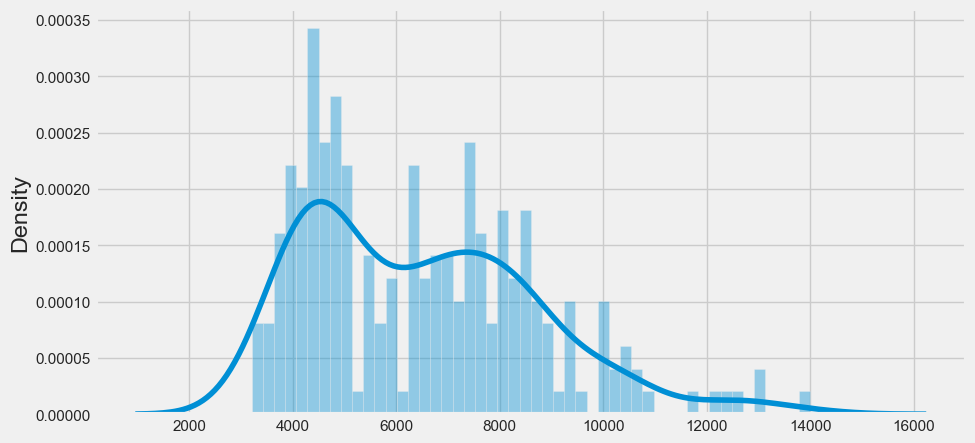

In [66]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [67]:
# Check which row does not have rate
proc_minutes_df.loc[proc_minutes_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


Meeting minutes includes various topics, so it makes sense to extract relevant sections. <br />
Check some common sections.

In [68]:
# Check what kind of sections are in common

a = minutes_df.contents.str.lower().str.count('staff economic outlook')
b = minutes_df.contents.str.lower().str.count('developments in financial markets')
c = minutes_df.contents.str.lower().str.count('staff review of the economic situation')
d = minutes_df.contents.str.lower().str.count('staff review of the financial situation')
e = minutes_df.contents.str.lower().str.count('participants\' views on current condition')
f = minutes_df.contents.str.lower().str.count('committee policy action')
g = minutes_df.contents.str.lower().str.count('voting for this action')
h = minutes_df.contents.str.lower().str.count('federal fund')

pd.options.display.max_rows = 300
pd.DataFrame({'date': minutes_df['date'], 'a': a, 'b':b, 'c':c, 'd':d, 'e':e, 'f':f, 'g':g, 'h':h})

,date,a,b,c,d,e,f,g,h
0,1993-02-03,0,0,0,0,0,0,0,1
1,1993-03-23,0,0,0,0,0,0,0,3
2,1993-05-18,0,0,0,0,0,0,0,1
3,1993-07-07,0,0,0,0,0,0,0,3
4,1993-08-17,0,0,0,0,0,0,0,1
5,1993-09-21,0,0,0,0,0,0,0,1
6,1993-11-16,0,0,0,0,0,0,0,1
7,1993-12-21,0,0,0,0,0,0,0,2
8,1994-02-04,0,1,0,0,0,0,0,0
9,1994-03-22,0,0,0,0,0,0,0,2


In [69]:
pd.options.display.max_rows = 20

Sections are added from time to time. For example, quarterly economic forcast started in 2009. Leave manually handling those for now, take another approach to filter sentenses by length and key words here.

In [70]:
proc_minutes_df = remove_short_section(proc_minutes_df, min_words=50)

### Split contents to max 200 words

In [71]:
split_minutes_df = get_split_df(proc_minutes_df)
print(split_minutes_df.shape)
split_minutes_df.tail(10)


(8505, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
8495,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,the possibility that progress on disinflation stalls or inflation reaccelerates because of continued momentum in economic activity A potential for a broadening of the armed conflict in the Middle ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8496,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,infrastructure being prepared to recover from such threats A few participants also discussed the importance of monitoring Treasury market functioning and potential vulnerabilities posed by the amo...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8497,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,the Committee's longer run goal of percent and participants remained resolute in their commitment to bring inflation down to the Committee's percent objective Participants also noted that tighter ...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8498,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,gather additional information to evaluate this progress All participants agreed that it was appropriate to continue the process of reducing the Federal Reserve's securities holdings as described i...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8499,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,in coming months would help clarify the extent to which the disinflation process was continuing aggregate demand was moderating in the face of tighter financial and credit conditions and labor mar...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..."
8500,minutes,2023-11-01,FOMC Meeting Minutes,other,200,0,5.25,2023-12-13,0,5.25,range for the federal funds rate Several participants commented on the recent decline in the use of the ON RRP facility noting that the use of the facility had been responsive to market conditions...,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system., Federal Open Market Committee, ...","The Federal Reserve, the central bank of the United States, provides\r\n the nation with a safe, flexible, and stable monetary and financial\r\n system.\n\n[SECTION]\n\nFederal O..

### Filter out by keywords

In [72]:
# Keep sections having keywords and long enough
keyword_minutes_df = remove_short_nokeyword(proc_minutes_df)
keyword_minutes_df.reset_index(drop=True, inplace=True)
print(keyword_minutes_df.shape)
keyword_minutes_df


(230, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,minutes,1993-02-03,FOMC Meeting Minutes,Alan Greenspan,2119,0,3.00,1993-02-18,0,3.00,"The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quarte...","[The nominal U.S. merchandise trade deficit widened slightly in November. For October and November together, however, the deficit narrowed a little from its average rate in the third quart...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, February 2, 1993, at..."
1,minutes,1993-03-23,FOMC Meeting Minutes,Alan Greenspan,1770,0,3.00,1993-05-18,0,3.00,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies fell on balance over the intermeeting period. The dollar depreciated through late...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a..."
2,minutes,1993-05-18,FOMC Meeting Minutes,Alan Greenspan,1182,0,3.00,1993-07-07,0,3.00,"In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated ...","[In foreign exchange markets, the trade-weighted value of the dollar in terms of the other G-10 currencies declined somewhat on balance over the intermeeting period. The dollar depreciated...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ..."
3,minutes,1993-07-07,FOMC Meeting Minutes,Alan Greenspan,2636,0,3.00,1993-08-17,0,3.00,"Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with me...","[Other short-term interest rates also were little changed on balance over the period since the May meeting. Early in the period, unexpectedly robust employment data for May, coupled with m...","A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3..."
4,minutes,1993-08-17,FOMC Meeting Minutes,Alan Greenspan,1272,0,3.00,1993-09-21,0,3.00,"Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped slig...","[Money market interest rates were little changed on balance over the intermeeting period, while rates on intermediate-term U.S. Treasury obligations and on fixed-rate mortgages dropped sli...","A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,minutes,2023-05-03,FOMC Meeting Minutes,other,839,1,5.00,2023-06-14,0,5.00,Oil prices edged down amid concerns about the global economic outlook. A slowing of retail energy inflation continued to contribute to an easing of headline consumer price inflation in many advanc...,[Oil prices edged down amid concerns about the global economic outlook. A slowing of retail energy inflation continued to contribute to an easing of headline consumer price inflation in many advan...,"

c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

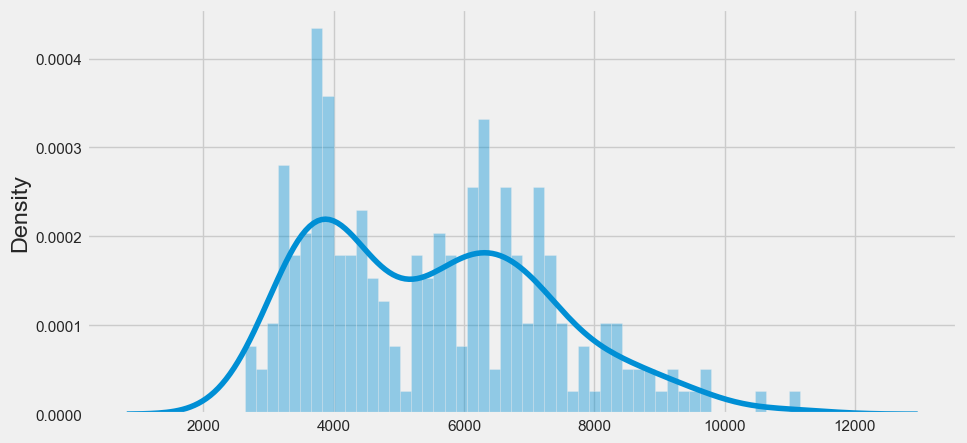

In [73]:
plt.figure(figsize=(10,5))
sns.distplot(proc_minutes_df["word_count"].values, bins=50)

In [74]:
# Drop text during the process to reduce the output size
proc_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
split_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)
keyword_minutes_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Press Conference Script DataFrame
Press Conference transcripts are available only from 2011

In [75]:
# Sample
print(presconf_script_df['contents'][2])

Now, the concerns that have been expressed relate to the possibility that the Fed's highly expansionary policies might be contributing to inflation risk. I would simply point to the record. If you look back for the last five years, inflation--although it's been volatile because of commodity price fluctuations--has averaged about 2 percent, which is close to a reasonable definition of price stability, whereas the area where we have fallen short, obviously, is on the unemployment side. So I think that criticisms based on the concern about inflation have so far, at least, not proved to be very valid.ding about Fed policy, in your opinion? CHAIRMAN BERNANKE. Well, politics is politics, and the Federal Reserve tries to stay nonpartisan and out of those debates. I mean, our job is to do the best we can for the U.S. economy, to do what we can to promote our mandate of maximum employment and price stability, and although we must be accountable to the Congress over the longer term, in the short

In [76]:
# Reorganize the dataframe
proc_presconf_script_df = reorganize_df(presconf_script_df, 'presconf_script')


No rate decision found:  0
Shape of the dataframe:  (60, 13)


In [77]:
# Check the returned dataframe
proc_presconf_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,8698,0,0.00,2011-06-22,0,0.00,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
1,presconf_script,2011-06-22,FOMC Press Conference Transcript,Ben Bernanke,7258,0,0.00,2011-08-01,0,0.00,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I'll briefly review today's policy decision. And I'll place the decision in the context of our economic projections and ...","[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I'll briefly review today's policy decision. And I'll place the decision in the context of our economic projections and...","CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I'll briefly review today's policy decision. And I'll place the decision in the context of our economic projections and ..."
2,presconf_script,2011-11-02,FOMC Press Conference Transcript,Ben Bernanke,7382,0,0.00,2011-11-28,0,0.00,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today's policy decision of the Federal Open Market Committee, and I will place that decision in ...","[CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today's policy decision of the Federal Open Market Committee, and I will place that decision in...","CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today's policy decision of the Federal Open Market Committee, and I will place that decision in ..."
3,presconf_script,2012-01-25,FOMC Press Conference Transcript,Ben Bernanke,9993,0,0.00,2012-03-13,0,0.00,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today's policy decision by the Federal Open Market Committee. And then I'll discuss next the consensus st...,[CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today's policy decision by the Federal Open Market Committee. And then I'll discuss next the consensus s...,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today's policy decision by the Federal Open Market Committee. And then I'll discuss next the consensus st...
4,presconf_script,2012-04-25,FOMC Press Conference Transcript,Ben Bernanke,7658,0,0.00,2012-06-20,-1,0.00,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I'll summarize today's policy action by the Federal Open Market Committee and then I'll place the Committee's policy decision in the ...","[CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I'll summarize today's policy action by the Federal Open Market Committee and then I'll place the Committee's policy decision in the...","CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I'll summarize today's policy action by the Federal Open Market Committee and then I'll place the Committee's policy decision in the ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,presconf_script,2023-06-14,FOMC Press Conference Transcript,other,8920,0,5.00,2023-07-26,1,5.25,CHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to promote maximum employment and stable prices for the American people. We understand

In [78]:
# Check which row does not have rate
proc_presconf_script_df.loc[proc_presconf_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text


### Split by speakers
Scripts contain words from different people, so split by the speaker

In [79]:
script_data_list = []

for i, row in tqdm(proc_presconf_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_presconf_script_df.columns

presconf_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
presconf_script_speaker_df

not matched:  PRELIMINARYTranscript of Chair Powell's Press Conference December 13, 2023
2023-12-13 00:00:00

not matched:  PRELIMINARYpercent for the year as a whole, bolstered by strong consumer demand as well as improving supply conditions. After picking up somewhat over the summer, activity in the housing sector has flattened out and remains well below the levels of a year ago, largely reflecting higher mortgage rates. Higher interest rates also appear to be weighing on business fixed investment. In our Summary of Economic Projections, Committee participants revised up their assessments of GDP growth this year but expect growth to cool, with the median projection falling to 1.4 percent next year.The labor market remains tight, but supply and demand conditions continue to come into better balance. Over the past three months, payroll job gains averaged 204 thousand jobs per month, a strong pace that is nevertheless below that seen earlier in the year. The unemployment rate remains lo

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1843,0,0.00,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0,0.00,2011-06-22,0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could y...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,314,0,0.00,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll al...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,57,0,0.00,2011-06-22,0,0.0,"Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar red...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,205,0,0.00,2011-06-22,0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. Let...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2398,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH,274,0,5.25,NaT,NaN,NaN,Let's go to Jennifer. JENNIFER SCHONBERGER. Thank you Chair Powell. Jennifer Schonberger with Yahoo Finance. You said back in July that you needed to start cutting rates befor

In [80]:
# Filter by the word count
presconf_script_speaker_df = presconf_script_speaker_df.loc[presconf_script_speaker_df['word_count'] >= 50]

(2012, 13)


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

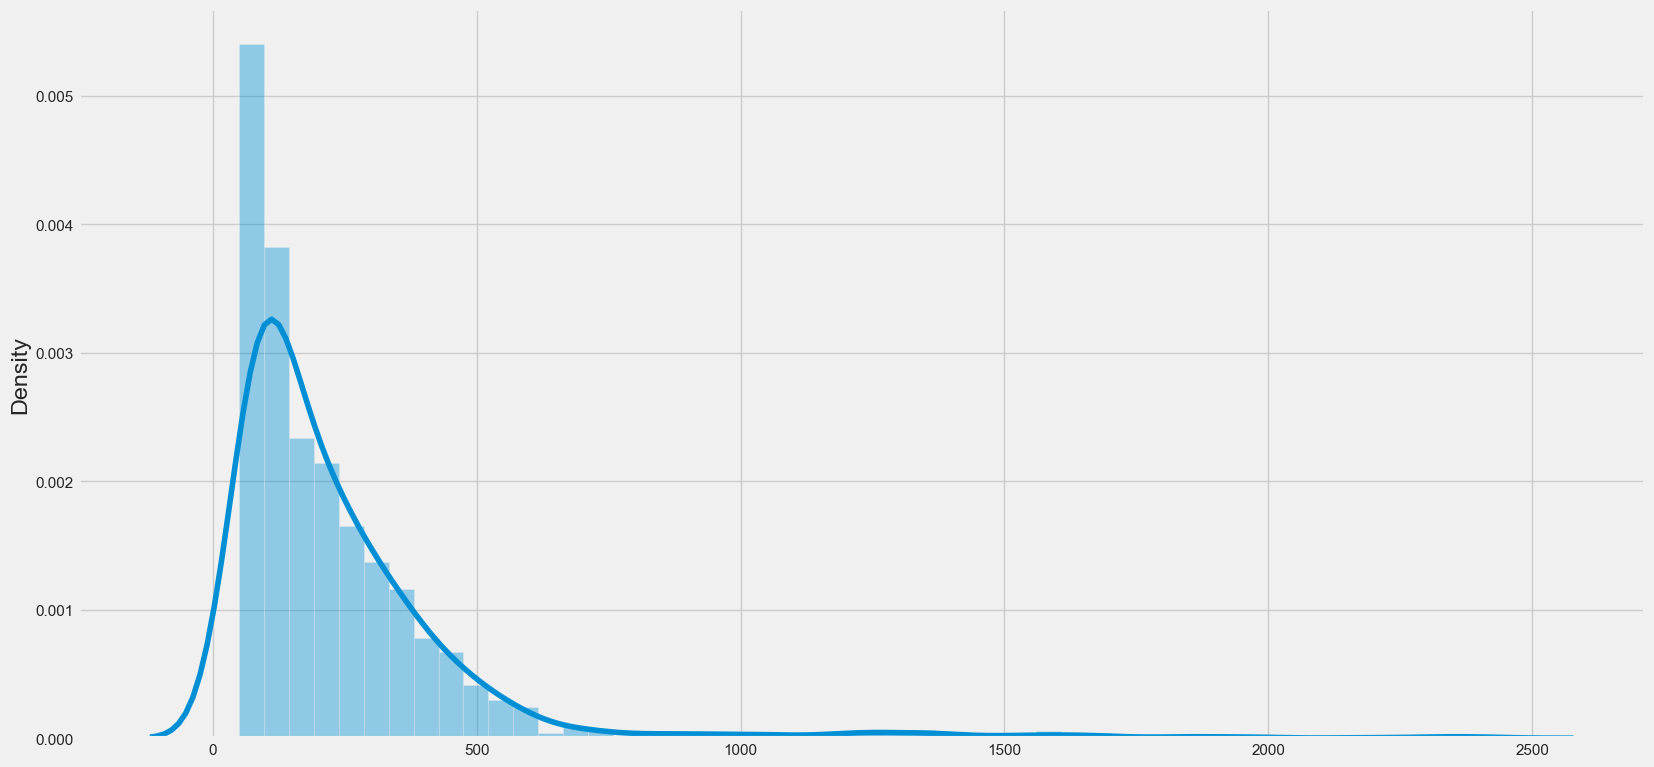

In [81]:
print(presconf_script_speaker_df.shape)
sns.distplot(presconf_script_speaker_df["word_count"].values, bins=50)

In [86]:
presconf_script_speaker_df.head( 
                                )

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,1843,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections ...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could y...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,314,0,0.0,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll al...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,57,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar red...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,CHAIRMAN BERNANKE,205,0,0.0,2011-06-22,0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. Let...","[CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly e...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."


In [87]:
# Filter to have only chairperson's speak

tmp_list = []
for i, row in presconf_script_speaker_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson:
        last_name_chairperson = chairperson.lower().split()[-1]
        if last_name_chairperson in row['speaker'].lower():
            row['speaker'] = chairperson
    tmp_list.append(list(row))

col_names = presconf_script_speaker_df.columns
presconf_script_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

In [88]:
# Combine scripts of the same speaker for the same day.
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', presconf_script_chair_df.shape)

for i, row in tqdm(presconf_script_chair_df.iterrows()):
    if (row['date'] == tmp_date) and (row['speaker'] == tmp_speaker):
        tmp_data[-1]['text'] += row['text']
        tmp_data[-1]['word_count'] += row['word_count']
        tmp_data[-1]['text_sections'].append(row['text'])
    else:
        tmp_date = row['date']
        tmp_speaker = row['speaker']
        row['text_sections'] = [row['text']]
        tmp_data.append(row)

presconf_script_chair_day_df = pd.DataFrame(tmp_data)

print('After', presconf_script_chair_day_df.shape)
presconf_script_chair_day_df.head()

Before:  (2012, 13)



After (1749, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1843,0,0.0,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections ...","[Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,56,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could y...","[Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could ...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,314,0,0.0,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll al...","[Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll a...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,57,0,0.0,2011-06-22,0,0.0,"Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar red...","[Mr. Chairman, first, thanks for doing this. This is a tremendous development. There are critics who say that Fed policy has driven down the value of the dollar, and a lower value to the dollar re...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,371,0,0.0,2011-06-22,0,0.0,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. Let...","[Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. Le...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."


/Users/yuki/miniconda3/envs/fomc/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

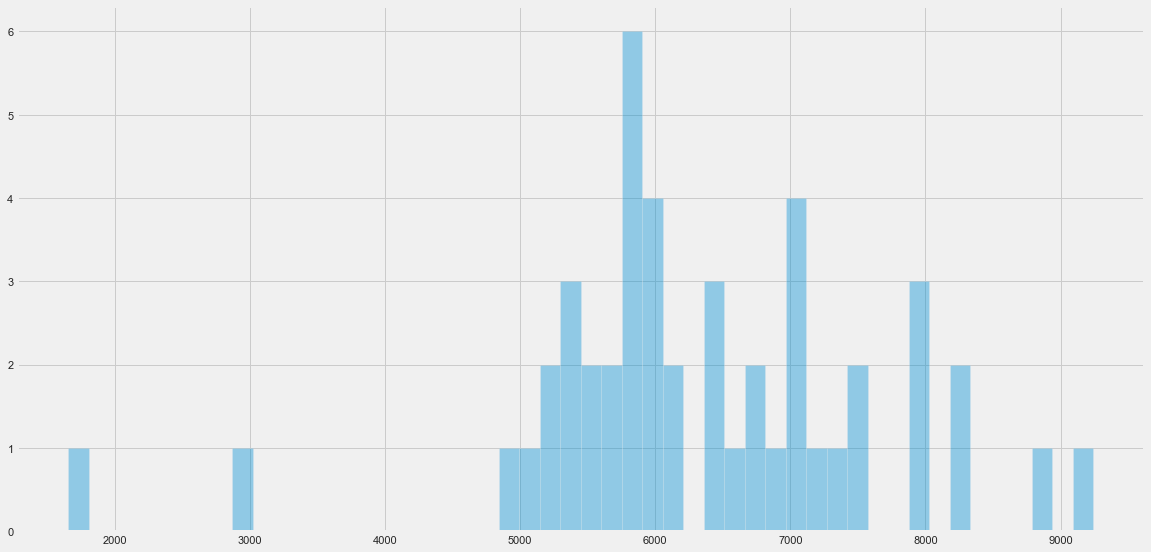

In [ ]:
sns.distplot(list(presconf_script_chair_day_df['word_count']), bins=50, kde=False)

In [ ]:
# # Check text
# print(presconf_script_chair_day_df['text'][0])

### Split contents to max 200 words

In [89]:
presconf_script_split_df = get_split_df(presconf_script_chair_day_df)
print(presconf_script_split_df.shape)
presconf_script_split_df.tail()


(3729, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
3724,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH. Jean Yung. JEAN YUNG,200,0,5.25,NaT,<NA>,NaN,Hi Chair Powell Jean Yung with Market News I wanted to go back to the stickiness of inflation question Over the past couple of years a lot of central bankers have talked about the more difficult l...,[Hi Chair Powell. Jean Yung with Market News. I wanted to go back to the stickiness of inflation question. Over the past couple of years a lot of central bankers have talked about the more difficu...,"PRELIMINARY\r\rTranscript of Chair Powell's Press Conference December 13, 2023\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to pr..."
3725,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH. Jean Yung. JEAN YUNG,199,0,5.25,NaT,<NA>,NaN,the supply side to recover because of lower demand We thought those two things were going to be necessary Sorry say the last part of your question again JEAN YUNG If there was something different ...,[Hi Chair Powell. Jean Yung with Market News. I wanted to go back to the stickiness of inflation question. Over the past couple of years a lot of central bankers have talked about the more difficu...,"PRELIMINARY\r\rTranscript of Chair Powell's Press Conference December 13, 2023\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to pr..."
3726,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH,200,0,5.25,NaT,<NA>,NaN,Okay We ll go to Megan for the last question MEGAN CASSELLA Hi Chair Powell Thanks for taking our questions Megan Cassella with Barron's I want to ask about the balance sheet given the Fed's focus...,[Okay. We'll go to Megan for the last question. MEGAN CASSELLA. Hi Chair Powell. Thanks for taking our questions. Megan Cassella with Barron's. I want to ask about the balance sheet given the Fed'...,"PRELIMINARY\r\rTranscript of Chair Powell's Press Conference December 13, 2023\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to pr..."
3727,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH,53,0,5.25,NaT,<NA>,NaN,moving up or as a result or holding steady At a certain point you know there won't be any more to come out of or there ll be a level where the reverse repo facility levels out And at that point re...,[Okay. We'll go to Megan for the last question. MEGAN CASSELLA. Hi Chair Powell. Thanks for taking our questions. Megan Cassella with Barron's. I want to ask about the balance sheet given the Fed'...,"PRELIMINARY\r\rTranscript of Chair Powell's Press Conference December 13, 2023\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to pr..."
3728,presconf_script,2023-12-13,FOMC Press Conference Transcript,CHAIR POWELL,115,0,5.25,NaT,<NA>,NaN,So I think they re on independent tracks You re asking though the question I guess you re implying the question of can you continue with QT at such time QT which is a tightening action at such tim...,"[So I think they're on independent tracks. You're asking, though, the question, I guess you're implying the question of can you continue with QT at such time, QT, which is a tightening action, at ...","PRELIMINARY\r\rTranscript of Chair Powell's Press Conference December 13, 2023\r\n\n[SECTION]\n\nCHAIR POWELL. Good afternoon. My colleagues and I remain squarely focused on our dual mandate to pr..."


### Filter out by keywords

In [90]:
# Keep sections having keywords and long enough
presconf_script_keyword_df = remove_short_nokeyword(presconf_script_chair_day_df)
presconf_script_keyword_df.reset_index(drop=True, inplace=True)
print(presconf_script_keyword_df.shape)
presconf_script_keyword_df


(477, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,1843,0,0.00,2011-06-22,0,0.0,"Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections ...","[Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly economic projections...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
1,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,314,0,0.00,2011-06-22,0,0.0,"Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll al...","[Well, currently as the statement suggests, we are in a moderate recovery. We'll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we'll a...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
2,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,496,0,0.00,2011-06-22,0,0.0,"Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a grea...","[Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a gre...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
3,presconf_script,2011-04-27,FOMC Press Conference Transcript,QUESTION,337,0,0.00,2011-06-22,0,0.0,Do you think it will be several months away? CHAIRMAN BERNANKE. It depends on the outlook. The Committee will have to make a judgment. QUESTION. Is it in the Fed's power to reduce the rate of unem...,[Do you think it will be several months away? CHAIRMAN BERNANKE. It depends on the outlook. The Committee will have to make a judgment. QUESTION. Is it in the Fed's power to reduce the rate of une...,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
4,presconf_script,2011-04-27,FOMC Press Conference Transcript,Ben Bernanke,480,0,0.00,2011-06-22,0,0.0,"Thank you. Well, first, I do believe that the second round of securities purchases was effective. We saw that first in the financial markets. The way monetary policy always works is by easing fina...","[Thank you. Well, first, I do believe that the second round of securities purchases was effective. We saw that first in the financial markets. The way monetary policy always works is by easing fin...","CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I'd like to briefly first review today's policy decision. I'll then turn next to the Federal Open Market Committee's quarterly ec..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
472,presconf_script,2023-12-13,FOMC Press Conference Transcript,MICHELLE SMITH. Jeanna. JEANNA SMIALEK,340,0,5.25,NaT,NaN,NaN,"Jeanna Smialek, New York Times. Thanks for taking our questions. In the SEP from today, growth is notably below potential in 2024. If growth were to surprise us aga

c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: >

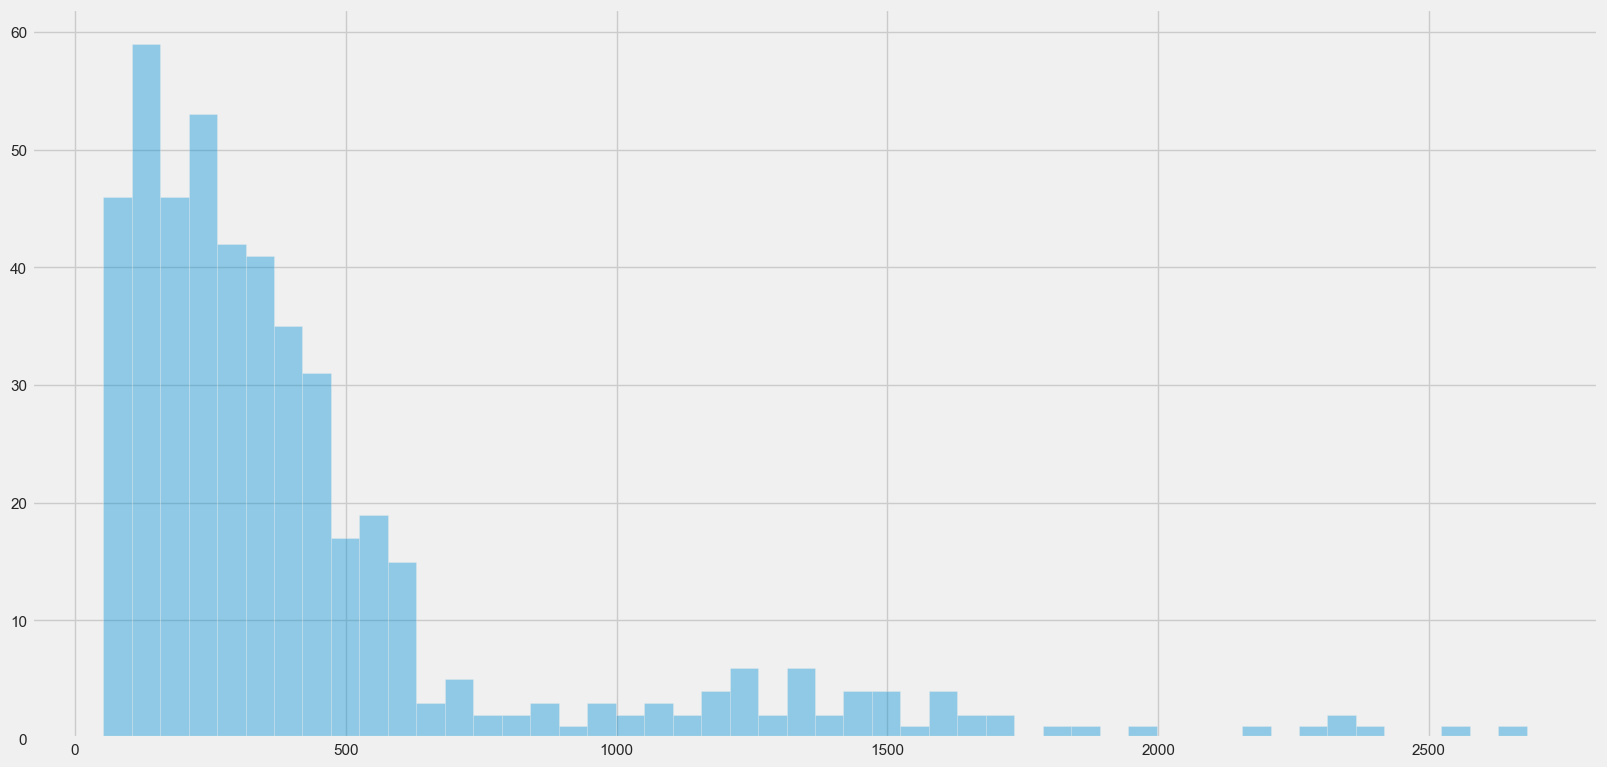

In [91]:
sns.distplot(list(presconf_script_keyword_df['word_count']), bins=50, kde=False)

In [92]:
# Drop text during the process to reduce the output size
presconf_script_chair_day_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
presconf_script_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Meeting Script DataFrame

In [93]:
# Sample
print(meeting_script_df['contents'][2])

CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have the election of officers. First of all, we have the election of the Chairman--I keep getting reminded that this position is not statutory --and we need a nomination.

[SECTION]

MR. SCHULTZ. Mr. Chairman, after great soul-searching until late last night, and contrary to the exhortations of many people around this table, I have decided to nominate Paul Volcker as Chairman of the FOMC!

[SECTION]

CHAIRMAN VOLCKER. Do we have a second?

[SECTION]

MR. PARTEE. Second. You saved him, Fred!

[SECTION]

MR. SCHULTZ. Pressure will do it every time!

[SECTION]

CHAIRMAN VOLCKER. Is there an objection? I shouldn't put it that way!

[SECTION]

MR. TIMLEN. I move that the nominations be closed.

[SECTION]

CHAIRMAN VOLCKER. Without objection. We need a Vice Chairman.

[SECTION]

MR. SCHULTZ. Mr. Chairman

In [94]:
# Reorganize the dataframe
proc_meeting_script_df = reorganize_df(meeting_script_df, 'meeting_script')


No rate decision found:  23
Shape of the dataframe:  (282, 13)


In [95]:
# Check the returned dataframe
proc_meeting_script_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45508,<NA>,NaN,NaT,<NA>,NaN,MR. STERNLIGHT. [Statement--see Appendix.][SECTION]CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?[SECTION]MR. STERNLIGHT. That was for all of '79.[SECTION]CHA...,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39915,<NA>,NaN,NaT,<NA>,NaN,CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on t...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on ...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on t...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,24094,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have ...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have ..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21353,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to yo...","[CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to y...","CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to yo..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24517,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes.[SECTION]MR. SCHULTZ. So moved.[SECTION]CHAIRMAN VOLCKER. Do we have a second?[SECTION]MS. TEETERS. Second.[S...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes., MR. SCHULTZ. So moved., CHAIRMAN VOLCKER. Do we have a second?, MS. TEETERS. Second., CHAIRMAN VOLCKER. Wi...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\r\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
277,meeting_script,2014-06-18,FOMC Meeting Transcript,Janet Yellen,88880,0,0.0,2014-07-30,0,0.0,"CHAIR YELLEN. I'd like to begin by welcoming three people to the table today: Stan Fischer, Lael Brainard, and Loretta Mester. This is the first FOMC meeting for both Stan and Lael, but both have ...","[CHAIR YELLEN. I'd like to begin by welcoming three people to the table today: S

In [96]:
# Check which row does not have rate
proc_meeting_script_df.loc[proc_meeting_script_df['rate'].isnull()]

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,other,45508,<NA>,NaN,NaT,<NA>,NaN,MR. STERNLIGHT. [Statement--see Appendix.][SECTION]CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?[SECTION]MR. STERNLIGHT. That was for all of '79.[SECTION]CHA...,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
1,meeting_script,1980-02-05,FOMC Meeting Transcript,other,39915,<NA>,NaN,NaT,<NA>,NaN,CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on t...,[CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on ...,CHAIRMAN VOLCKER. I will call the non-meeting to order. We are not in a meeting at this point anyway; we may be in a meeting later. I would just remind all of you that I sent out a memorandum on t...
2,meeting_script,1980-03-18,FOMC Meeting Transcript,other,24094,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have ...","[CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have...","CHAIRMAN VOLCKER. The meeting can come to order, gentlemen and lady. We have a lot of business to dispose of at the start and I will try to find my agenda, if you will excuse me a moment. We have ..."
3,meeting_script,1980-04-22,FOMC Meeting Transcript,other,21353,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to yo...","[CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to y...","CHAIRMAN VOLCKER. Can we come to order, ladies and gentlemen? I am delighted to say that our Vice Chairman, Mr. Solomon, who was duly elected in absentia last time, is with us today. Welcome to yo..."
4,meeting_script,1980-05-20,FOMC Meeting Transcript,other,24517,<NA>,NaN,NaT,<NA>,NaN,"CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes.[SECTION]MR. SCHULTZ. So moved.[SECTION]CHAIRMAN VOLCKER. Do we have a second?[SECTION]MS. TEETERS. Second.[S...","[CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes., MR. SCHULTZ. So moved., CHAIRMAN VOLCKER. Do we have a second?, MS. TEETERS. Second., CHAIRMAN VOLCKER. Wi...","CHAIRMAN VOLCKER. Let us proceed, ladies and gentlemen. We need to approve the minutes.\r\n\n[SECTION]\n\nMR. SCHULTZ. So moved.\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. Do we have a second?\r\n\n[SECT..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18,meeting_script,1982-02-02,FOMC Meeting Transcript,other,55795,<NA>,NaN,NaT,<NA>,NaN,"MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL. [Statements and related charts--see Appendix.][SECTION]CHAIRMAN VOLCKER. Do we have any comments or questions on how these people see things?[SECTION]VI...","[MESSRS. KICHLINE, ZEISEL, TRUMAN and PRELL. [Statements and related charts--see Appendix

(282, 13)


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

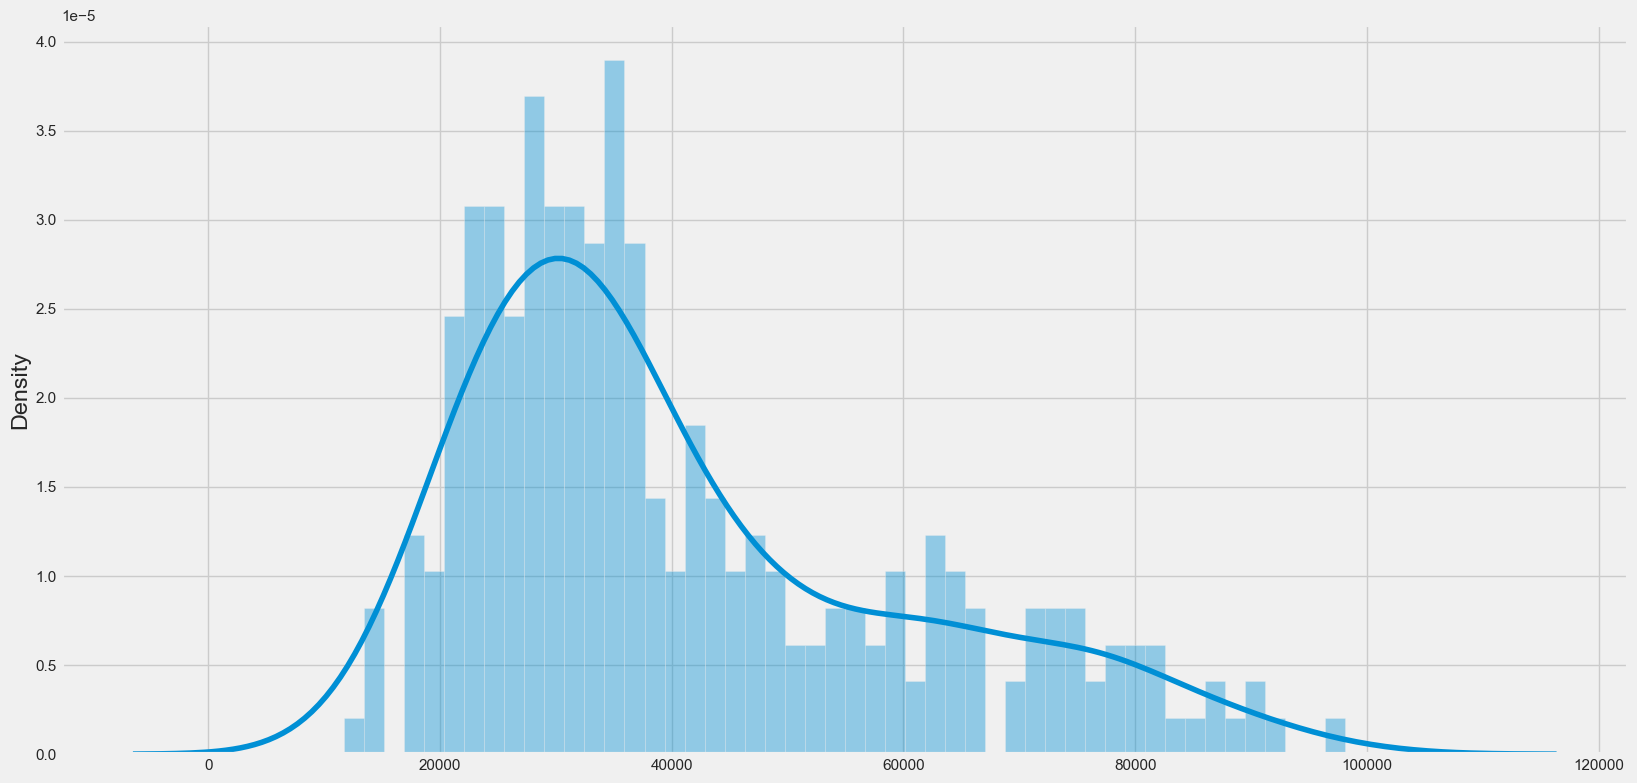

In [97]:
print(proc_meeting_script_df.shape)
sns.distplot(proc_meeting_script_df["word_count"].values, bins=50)

### Split by speakers
Scripts contain words from different people, so split by the speaker

In [98]:
script_data_list = []

for i, row in tqdm(proc_meeting_script_df.iterrows()):
    for text in row["text_sections"]:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, text = match[0]
            row['speaker'] = speaker
            row['text'] = text
            row['word_count'] = len(re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text))
            script_data_list.append(list(row))

col_name = proc_meeting_script_df.columns

meeting_script_speaker_df = pd.DataFrame(script_data_list, columns = col_name)
meeting_script_speaker_df

not matched:  SPEAKER(?). If it wasn't a coincidence, it's wonderful.
1980-01-09 00:00:00

not matched:  [CHAIRMAN VOLCKER]. If it was far off, the staff would say it was a coincidence!away!
1980-01-09 00:00:00

not matched:  [CHAIRMAN VOLCKER. Mr. Willes.]
1980-01-09 00:00:00

not matched:  SPEAKER(?). Yes, I'd do that too, but we still don't know what the limits are. I don't think we know the magnitude of the problems yet and at what point the problems become a policy decision rather than a technical adjustment.1/8-9/80-17-
1980-01-09 00:00:00

not matched:  MR. KICHLINE(?). Well, that's part of it, but it's not a major cranking up of the tandem plan. As you know, the budgetary impact there is quite variable; it depends on when the government sells those mortgages. It's an interest [subsidy] that ultimately shows up in the federal expenditures. On the authorizations, that's a difficult question because we have built in a significant increase in defense expenditures along the lines o

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. STERNLIGHT,3,NaN,NaN,NaT,NaN,NaN,[Statement--see Appendix.],"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
1,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,11,NaN,NaN,NaT,NaN,NaN,[That was the change in System holdings of securities] since when?,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
2,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. STERNLIGHT,5,NaN,NaN,NaT,NaN,NaN,That was for all of '79.,"[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
3,meeting_script,1980-01-09,FOMC Meeting Transcript,CHAIRMAN VOLCKER,27,NaN,NaN,NaT,NaN,NaN,"Steve, if you want to add something that bears upon the nature of the operations, this is probably as good a time as any to do it.","[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
4,meeting_script,1980-01-09,FOMC Meeting Transcript,MR. AXILROD,1299,NaN,NaN,NaT,NaN,NaN,"Mr. Chairman, we have some tables we could pass out, which are somewhat similar to the ones that we made available to the Committee at the last meeting and which might be helpful in considering ho...","[MR. STERNLIGHT. [Statement--see Appendix.], CHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?, MR. STERNLIGHT. That was for all of '79., CHAIRMAN VOLCKER. Steve...",MR. STERNLIGHT. [Statement--see Appendix.]\r\n\n[SECTION]\n\nCHAIRMAN VOLCKER. [That was the change in System holdings of securities] since when?\r\n\n[SECTION]\n\nMR. STERNLIGHT. That was for all...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
88431,meeting_script,2014-12-17,FOMC Meeting Transcript,CHAIR YELLEN,78,0,0.0,2017-06-14,1,NaN,"Thank you. Okay. I think the main open issue in the statement is thebracketed word ""somewhat"" in paragraph 1, and I heard one, two, three, four, five, six--eightpeople propose removing it. I'm cer...","[CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The firstitem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to closethe Board meeting., ...","CHAIR YELLEN. Good afternoon, everyone. I think we are ready to begin. The first\ritem we are going to consider is in a joint Board and FOMC meeting, so I need a motion to close\rthe Board meeting..."
88432,meeting_script,2014-12-17,FOMC Meeting Transcript,MR. LUECKE,46,0,0.0,2017-06-14,1,NaN,"This vote, as Chair Yellen indicated, will be on alternative B, depictedon pages 6 and 7 of Bill English's handout. I

Some are not matching the defined patterns but those unmatched ones do not look importnant. Thus ignore them here.

In [99]:
# Filter by word count having 20 or more.
print("Before: ", meeting_script_speaker_df.shape)
meeting_script_speaker_df = meeting_script_speaker_df.loc[meeting_script_speaker_df['word_count'] >= 20]
print("After: ", meeting_script_speaker_df.shape)

Before:  (88436, 13)
After:  (47690, 13)


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

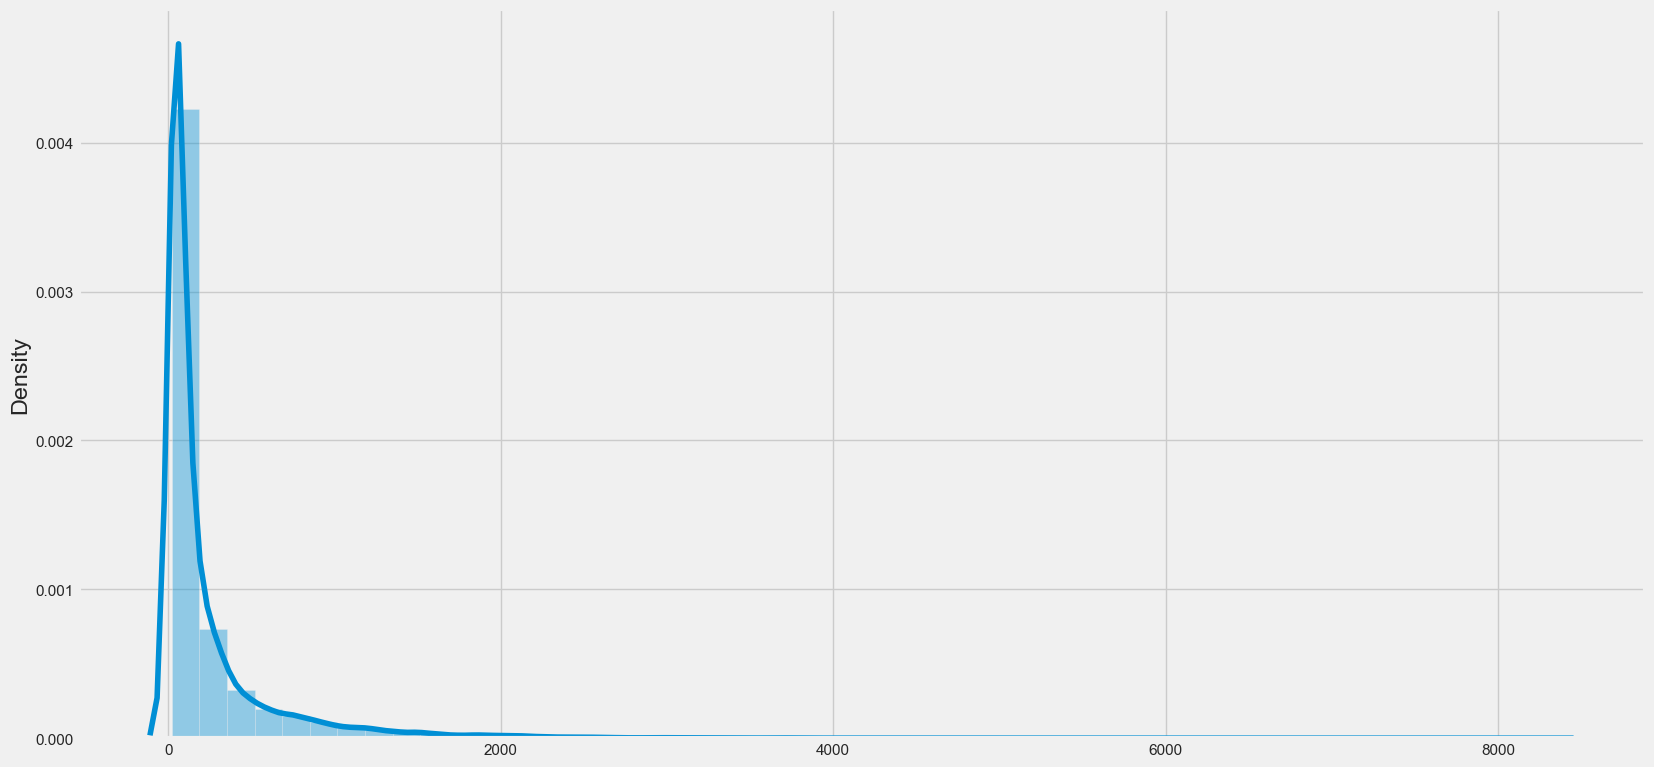

In [100]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

In [101]:
# Combine scripts for the same day.
meeting_script_speaker_df = meeting_script_speaker_df.groupby(['type', 'date', 'title', 'speaker', 'decision', 'rate', 'next_meeting', 'next_decision', 'next_rate'])['text'].apply('[SECTION]'.join).reset_index()
meeting_script_speaker_df['text_sections'] = meeting_script_speaker_df['text'].map(lambda x: x.split("[SECTION]"))
meeting_script_speaker_df['text'] = meeting_script_speaker_df['text'].map(lambda x: x.replace("[SECTION]", ""))
meeting_script_speaker_df['word_count'] = meeting_script_speaker_df['text'].map(get_word_count)
meeting_script_speaker_df


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,"Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam s...","[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",11366
1,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. AXILROD,-1,9.5,1982-11-16,-1,9.0,"We could make efforts to make shift adjustments in somewhat the same way, probably with the same degree of credibility.If there were not a specification for M1 and there were for M2 or M3, we woul...","[We could make efforts to make shift adjustments in somewhat the same way, probably with the same degree of credibility., If there were not a specification for M1 and there were for M2 or M3, we w...",836
2,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BALLES,-1,9.5,1982-11-16,-1,9.0,"Well, coming at this confidence factor from a little different direction, since as we all know both consumer confidence and business confidence do play a key part in what really happens, and both ...","[Well, coming at this confidence factor from a little different direction, since as we all know both consumer confidence and business confidence do play a key part in what really happens, and both...",801
3,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BLACK,-1,9.5,1982-11-16,-1,9.0,"Mr. Chairman, Larry rescued us from the straits of desperation and said some of the things I had in mind. There are two things that might be helpful to remember here. One is that it always looks v...","[Mr. Chairman, Larry rescued us from the straits of desperation and said some of the things I had in mind. There are two things that might be helpful to remember here. One is that it always looks ...",645
4,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BOEHNE,-1,9.5,1982-11-16,-1,9.0,"I have a question. Your forecast and almost all the forecasts have a phrase in them that says something like: ""The consumer is going to lead us out of this recession,"" and economic logic would sug...","[I have a question. Your forecast and almost all the forecasts have a phrase in them that says something like: ""The consumer is going to lead us out of this recession,"" and economic logic would su...",585
...,...,...,...,...,...,...,...,...,...,...,...,...
9847,meeting_script,2014-10-29,FOMC Meeting Transcript,MS. LOGAN,1,0.0,2014-12-17,0,0.0,"Thank you, Madam Chair. I'll begin by discussing financial markets and Desk operations over the intermeeting period. Simon will briefly review three staff memos that you received prior to the meet...","[Thank you, Madam Chair. I'll begin by discussing financial markets and Desk operations over the intermeeting period. Simon will briefly review three staff memos that you received prior to the mee...",2697
9848,meeting_script,2014-10-29,FOMC Meeting Transcript,MS. MESTER,1,0.0,2014-12-17,0,0.0,"I have a question on each part of the proposal. Are you intending torecommend any further testing in December? If so, what would those tests be? And then, on thevolatility and the term RRPs, we ha...","[I have a question on each part of the proposal. Are you intending torecommend any further testing in December? If so, what would those tests be? And then, on thevolatility and the term RRPs, we h...",824
9849,meeting_script,2014-10-29,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY,1,0.0,2014-12-17,0,0.0,"They're expressing the views of others. Just like everyone around the table could have a view. We could wrongly express our view of others, right?Yes, what's different is that this time we are goi...","[They're expressing the views of others. Just like eve

c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

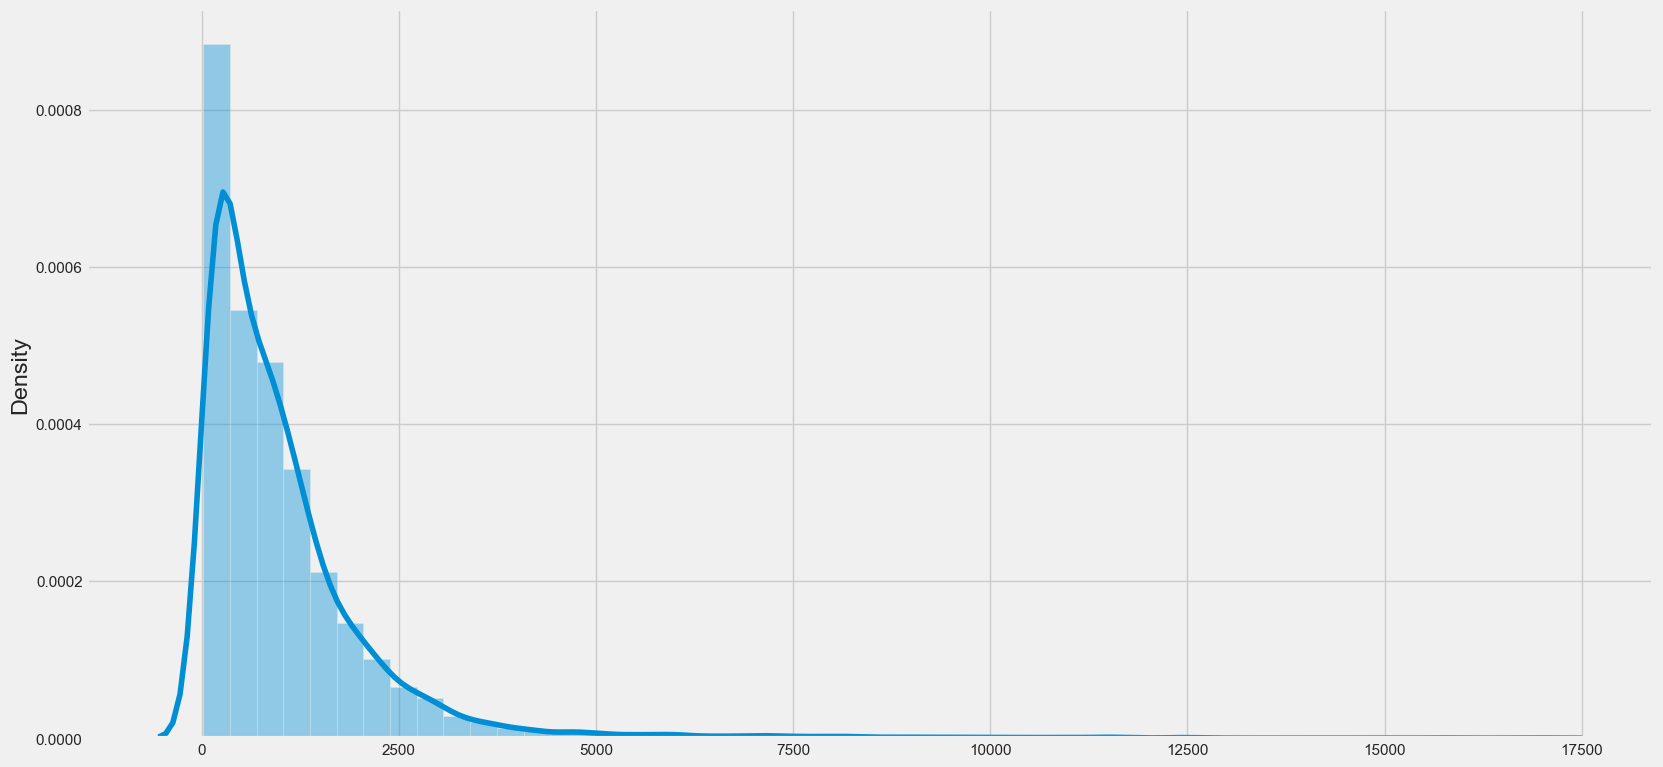

In [102]:
sns.distplot(meeting_script_speaker_df["word_count"].values, bins=50)

### Split contents to max 200 words

In [103]:
meeting_script_split_df = get_split_df(meeting_script_speaker_df)
print(meeting_script_split_df.shape)
meeting_script_split_df


(69782, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,Well I want to come back to some of these questions later I think it's better to take them up later in the context of the whole policy problem But immediately we intervened yesterday as Sam said a...,"[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",200
1,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,claim in effect on any Fund drawing that the Mexicans make assuming they come to some conclusion with the Fund We ll consider that at the time But as to the immediate rollover we can roll that ove...,"[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",200
2,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,don't know the survey but what surprised me is that they said prices are going to be I forget precisely what number they used to percent above last year That surprised me a little because I though...,"[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",200
3,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,the same degree of credibility however great that was as last time Yes but I m not sure it makes any difference analytically It makes a difference in the number obviously But in either case we won...,"[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",200
4,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,only thing that will be yes and no is the answer I think Obviously we can study the matter I see no prospect that any amount of study is going to tell us what the behavior of is going to be in the...,"[Well, I want to come back to some of these questions later. I think it's better to take them up later in the context of the whole policy problem. But immediately, we intervened yesterday, as Sam ...",200
...,...,...,...,...,...,...,...,...,...,...,...,...
69777,meeting_script,2014-10-29,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY. Okay. Good. CHAIR YELLEN. President Kocherlakota. MR. KOCHERLAKOTA,1,0.0,2014-12-17,0,0.0,Thank you Madam Chair I had a comment and a question My comment builds on the conversation we had earlier about market based measures of inflation compensation I know that Tealbook Book A makes si...,"[Thank you, Madam Chair. I had a comment and a question. My comment builds on the conversation we had earlier about market-based measures of inflation compensation. I know that Tealbook, Book A, m...",200
69778,meeting_script,2014-10-29,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY. Okay. Good. CHAIR YELLEN. President Kocherlakota. MR. KOCHERLAKOTA,1,0.0,2014-12-17,0,0.0,to be not just how likely they are going to be And I think that's something we should be taking into account in our own assessments of policy So I hope the analysis presented to the FOMC by the st...,"[Thank you, Madam Chair. I had a comment and a question. My comment builds on the conversation we had earlier about market-based measures of inflation compensation. I know that Tealbook, Book A, m...",200
69779,meeting_script,2014-10-29,FOMC Meeting Transcript,VICE CHAIRMAN DUDLEY. Okay. Good. CHAIR YELLEN. President Kocherlakota. MR. KOCHERLAKOTA,1,0.0,2014-12-17,0,0.0,formed and what October of

### Filter out by keywords

In [104]:
# Keep sections having keywords and long enough
meeting_script_keyword_df = remove_short_nokeyword(meeting_script_speaker_df)
meeting_script_keyword_df.reset_index(drop=True, inplace=True)
print(meeting_script_keyword_df.shape)
meeting_script_keyword_df


(5858, 12)


,type,date,title,speaker,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,word_count
0,meeting_script,1982-10-05,FOMC Meeting Transcript,CHAIRMAN VOLCKER,-1,9.5,1982-11-16,-1,9.0,"I think there will be a tendency among some to pay a money market funds rate plus; the question is whether the market gets driven there. I'm just guessing. Among other things, we approved what I t...","[I think there will be a tendency among some to pay a money market funds rate plus; the question is whether the market gets driven there. I'm just guessing. Among other things, we approved what I ...",5287
1,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BLACK,-1,9.5,1982-11-16,-1,9.0,"Mr. Chairman, we are all in agreement on only one thing, I think: that we would like to see interest rates come down. I would like to raise the question of whether it might not be reasonable to su...","[Mr. Chairman, we are all in agreement on only one thing, I think: that we would like to see interest rates come down. I would like to raise the question of whether it might not be reasonable to s...",194
2,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. BOEHNE,-1,9.5,1982-11-16,-1,9.0,"Well, I think how one comes out on this depends on whether one wants to take the risks on rules or on the side of discretion. It does seem to me that we have pushed the domestic economy and the fi...","[Well, I think how one comes out on this depends on whether one wants to take the risks on rules or on the side of discretion. It does seem to me that we have pushed the domestic economy and the f...",193
3,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. CORRIGAN,-1,9.5,1982-11-16,-1,9.0,"Mr. Chairman, I clearly would fall on the side of the argument that says we don't want an increase in interest rates, even by accident. An increase in interest rates in the current setting, even i...","[Mr. Chairman, I clearly would fall on the side of the argument that says we don't want an increase in interest rates, even by accident. An increase in interest rates in the current setting, even ...",272
4,meeting_script,1982-10-05,FOMC Meeting Transcript,MR. FORD,-1,9.5,1982-11-16,-1,9.0,"What you are saying quite plainly, if I hear you correctly, is that you think rates are too high now and you don't want even a tiny increase from the present rate of 10-1/4 percent on the fed fund...","[What you are saying quite plainly, if I hear you correctly, is that you think rates are too high now and you don't want even a tiny increase from the present rate of 10-1/4 percent on the fed fun...",45
...,...,...,...,...,...,...,...,...,...,...,...,...
5853,meeting_script,2014-10-29,FOMC Meeting Transcript,MR. WILLIAMS,1,0.0,2014-12-17,0,0.0,"Indeed, there is. CHAIR YELLEN. I surely would want to do nothing to make it difficult for you to watch. MR. TARULLO. I thought you said you needed to get home to watch the game. CHAIR YELLEN. I'm...","[Indeed, there is. CHAIR YELLEN. I surely would want to do nothing to make it difficult for you to watch. MR. TARULLO. I thought you said you needed to get home to watch the game. CHAIR YELLEN. I'...",2030
5854,meeting_script,2014-10-29,FOMC Meeting Transcript,MS. GEORGE,1,0.0,2014-12-17,0,0.0,"While the stronger dollar and weaker foreign growth may tend to damp U.S. growth, I see the decline in both oil prices and longer-term interest rates providing a countervailing impetus to economic...","[While the stronger dollar and weaker foreign growth may tend to damp U.S. growth, I see the decline in both oil prices and longer-term interest rates providing a countervailing impetus to economi...",380
5855,meeting_script,2014-10-29,FOMC Meeting Transcript,MS. LIANG,1,0.0,2014-12-17,0,0.0,"Thank you, Steve. I will be referring to ""Material for Briefing on Financial Stability Developments."" My briefing today summarizes our recent QS financial stability assessment. Recent financial ma...","[Thank you, Steve. I will be referring to ""Material for Briefing o

In [105]:
# Drop text during the process to reduce the output size
meeting_script_speaker_df.drop(columns=['text_sections'], inplace=True)
meeting_script_split_df.drop(columns=['text_sections'], inplace=True)
meeting_script_keyword_df.drop(columns=['text_sections'], inplace=True)

## Speech DataFrame

In [106]:
# Reorganize the dataframe
proc_speech_df = reorganize_df(speech_df, 'speech')

No rate decision found:  1711
Shape of the dataframe:  (1711, 13)


In [107]:
# Check the returned dataframe
# Note that rate and decision are not applicable because speech is not at FOMC meeting
proc_speech_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3211,<NA>,None,1996-07-03,0,5.25,"Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996[SECTION][SECTION]I am honored to present...","[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2694,<NA>,None,1996-07-03,0,5.25,"Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996[SECTION][SECTION]It is a pleasure to be here th...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2912,<NA>,None,1996-09-24,0,5.25,Monetary Policy Objectives and Strategy[SECTION]I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1984,<NA>,None,1996-09-24,0,5.25,"Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996[SE...","[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2180,<NA>,None,1996-11-13,0,5.25,"Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996[SECTION][SECTION]Small Business Is Big Business[SECTION]It is my pleasure to ...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,speech,2023-11-28,Reflections on the Economy and Monetary Policy,Governor Michelle W. Bowman,3328,<NA>,None,2023-12-13,0,5.25,"The Federal Reserve, the central bank of the United States, provides the natio

(1711, 13)


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

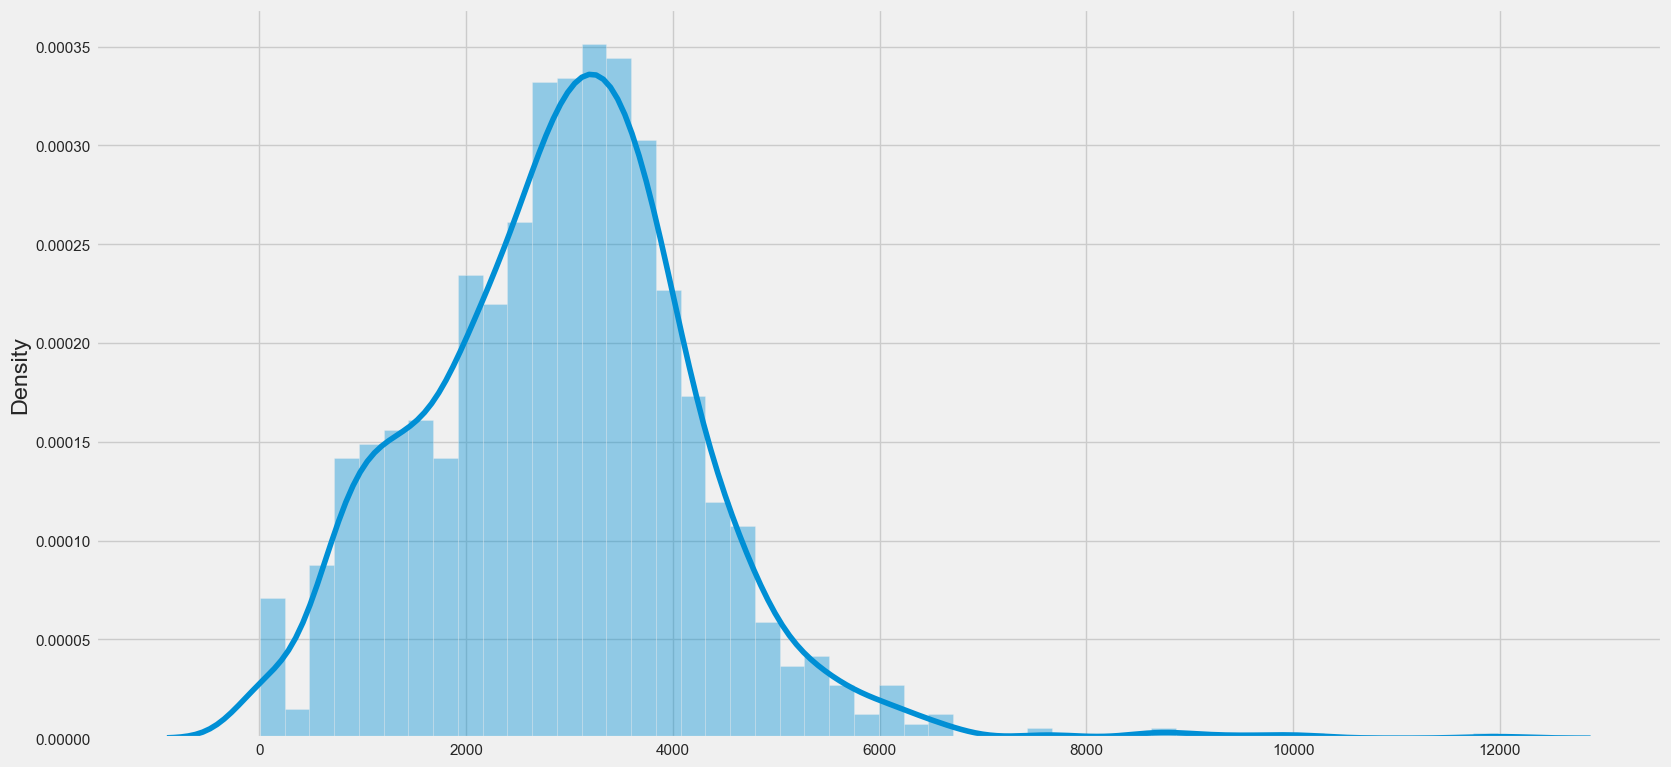

In [108]:
print(proc_speech_df.shape)
sns.distplot(proc_speech_df["word_count"].values, bins=50)

In [109]:
# Check records where speaker is null
proc_speech_df['speaker'].isnull().sum()

0

In [110]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_speech_df = remove_short_section(proc_speech_df, min_words=50)
proc_speech_df


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Chairman Alan Greenspan,3095,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world. I am especially delighted to have with us B...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-18,Developments in electronic money and banking,"Governor Edward W. Kelley, Jr.",2659,<NA>,None,1996-07-03,0,5.25,"It is a pleasure to be here this afternoon to provide the Federal Reserve's perspective on recent developments in the field of electronic money and banking. To begin, let me remind yo...","[Remarks by Governor Edward W. Kelley, Jr.Developments in electronic money and bankingAt the CyberPayments '96 Conference, Dallas, TexasJune 18, 1996, , It is a pleasure to be here this afternoon ...","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i..."
2,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,2729,<NA>,None,1996-09-24,0,5.25,I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emphasize the importance of setting monetary ...,"[Monetary Policy Objectives and Strategy, I want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also want to emp...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
3,speech,1996-09-19,Regulation and electronic payment systems,Chairman Alan Greenspan,1584,<NA>,None,1996-09-24,0,5.25,You have heard many points of view today on electronic moneyand banking. New products are being designed to challenge theuse of currency and checks in millions of routine consumertransactions. O...,"[Remarks by Chairman Alan GreenspanRegulation of electronic payment systemsAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC September 19, 1996, ...","Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1..."
4,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,2002,<NA>,None,1996-11-13,0,5.25,"A fair question might be, what is the nation's central bank doing sponsoring aconference on small business? Well, let me be clear about one thing, neither I nor mycolleagues from the Fed are goi...","[Remarks by Governor Lawrence B. LindseyAt the Small Business Development Conference, Richmond, VirginiaOctober 2, 1996, , Small Business Is Big Business, It is my pleasure to be here today at the...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1706,speech,2023-11-28,Reflections on the Economy and Monetary Policy,Governor Michelle W. Bowman,3147,<NA>,None,2023-12-13,0,5.25,It is a pleasure to join you this morning in Salt Lake City for the Utah Banker and Business Leader Breakfast.1 I

In [112]:
tmp_list = []
for i, row in proc_speech_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson:
        last_name_chairperson = chairperson.lower().split()[-1]
        if last_name_chairperson in row['speaker'].lower():
            row['speaker'] = chairperson
    tmp_list.append(list(row))

col_names = proc_speech_df.columns
speech_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)

print(speech_chair_df.shape)
print(speech_chair_df)

(1695, 13)
        type       date  \
0     speech 1996-06-13   
1     speech 1996-06-18   
2     speech 1996-09-08   
3     speech 1996-09-19   
4     speech 1996-10-02   
...      ...        ...   
1690  speech 2023-11-28   
1691  speech 2023-11-28   
1692  speech 2023-12-01   
1693  speech 2023-12-01   
1694  speech 2023-12-05   

                                                                            title  \
0                                             Bank supervision in a world economy   
1                                    Developments in electronic money and banking   
2                                         Monetary policy objectives and strategy   
3                                       Regulation and electronic payment systems   
4                                                  Small business is big business   
...                                                                           ...   
1690                               Reflections on the Economy and Mon

### Split contents to max 200 words

In [113]:
speech_split_df = get_split_df(speech_chair_df)
speech_split_df.reset_index(drop=True, inplace=True)
print(speech_split_df.shape)
speech_split_df


(31033, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,I am honored to present the William Taylor Memorial Lecture to such a distinguished group of senior bank supervisors from around the world I am especially delighted to have with us Bill's wife Sha...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
1,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,best from himself and from those around him He understood that a safe and sound banking system was essential to a healthy market system and he was committed to maintaining such a system His contri...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
2,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,reflect the increased efficiency of financial markets worldwide which have helped to bring about expanded international trade and economic growth However by strengthening the interdependencies amo...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
3,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,relationship we may have a better framework for considering how to supervise and regulate our financial institutions A Leveraged Banking System In addressing these issues it is important to rememb...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
4,speech,1996-06-13,Bank supervision in a world economy,Alan Greenspan,200,<NA>,None,1996-07-03,0,5.25,of intermediation with the founding of the Riksbank more than years ago as a private institution Of course this same leverage and risk taking also greatly increases the possibility of bank failure...,"[Remarks by Chairman Alan GreenspanBank supervision in a world economyAt the International Conference of Banking Supervisors, Stockholm, SwedenJune 13, 1996, , I am honored to present the William ...","Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31028,speech,2023-12-05,Building a More Inclusive Financial System through Collaboration and Action,Governor Michelle W. Bowman,200,<NA>,None,2023-12-13,0,5.25,driven organizations I will turn now to the Fed's efforts to build the institutional capacity of a set of key stakeholders Minority De

### Filter out by keyword

In [114]:
# Keep sections having keywords and long enough
speech_keyword_df = remove_short_nokeyword(speech_chair_df)
speech_keyword_df.reset_index(drop=True, inplace=True)
print(speech_keyword_df.shape)
speech_keyword_df


(878, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,speech,1996-09-08,Monetary policy objectives and strategy,Governor Laurence H. Meyer,897,NaN,NaN,1996-09-24,0,5.25,"Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So don't saddle monetary policy w...","[Economic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So don't saddle monetary policy ...",Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...
1,speech,1996-10-02,Small business is big business,Governor Lawrence B. Lindsey,470,NaN,NaN,1996-11-13,0,5.25,"But, even those businesses which do not become industrial behemoths still have a vitalrole to play. Small businesses build our homes and unclog the drains when they get full, theymonitor our heal...","[But, even those businesses which do not become industrial behemoths still have a vitalrole to play. Small businesses build our homes and unclog the drains when they get full, theymonitor our hea...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S..."
2,speech,1996-10-05,"Bank supervision, regulation, and risk",Alan Greenspan,136,NaN,NaN,1996-11-13,0,5.25,"While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing shareh...","[While awaiting perfection, it is useful to underline that regulators and banks have acommon interest in using the evolving new technologies to meet their own separateobjectives: maximizing share...","Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\..."
3,speech,1996-10-09,Here we go again?,Governor Lawrence B. Lindsey,470,NaN,NaN,1996-11-13,0,5.25,Without any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Let's do th...,[Without any question the most important economic development has been a decline in the underlying rate of inflation and the consequent decline in medium- and long-term interest rates. Let's do t...,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan..."
4,speech,1996-10-11,How to grow faster,Governor Lawrence B. Lindsey,544,NaN,NaN,1996-11-13,0,5.25,"There is, however, one option that from time immemorial always seems to find its wayinto the political discourse: print money. This year we have frequently heard from variousquarters that it is ...","[There is, however, one option that from time immemorial always seems to find its wayinto the political discourse: print money. This year we have frequently heard from variousquarters that it is...","Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,speech,2023-11-16,"Global Linkages: Supply, Spillovers, and Common Challenges",Governor Lisa D. Cook,500,NaN,NaN,2023-12-13,0,5.25,"With inflation unacceptably high, monetary policy turned toward tightening. Central banks in several emerging market economies began to tighten first, see

In [115]:
# Drop text_sections
speech_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
speech_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Testimony DataFrame

In [116]:
# Reorganize the dataframe
# Note that rate and decision are not applicable because testimony is not at FOMC meeting
proc_testimony_df = reorganize_df(testimony_df, 'testimony')

No rate decision found:  466
Shape of the dataframe:  (466, 13)


In [117]:
# Check the returned dataframe
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2298,<NA>,None,1996-07-03,0,5.25,[SECTION][SECTION][SECTION][SECTION]It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent pub...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",1227,<NA>,None,1996-08-20,0,5.25,"[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past s...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,3372,<NA>,None,1996-08-20,0,5.25,"Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996[SECTION]Before I t...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2878,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in thi...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3764,<NA>,None,1996-08-20,0,5.25,[SECTION][SECTION][SECTION][SECTION]I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevan...,"[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,testimony,2023-06-21,Nomination hearing,Governor Lisa D. Cook,900,<NA>,None,2023-07-26,1,5.25,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, f

(466, 13)


c:\Users\luisl\anaconda3\envs\fomc\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<Axes: ylabel='Density'>

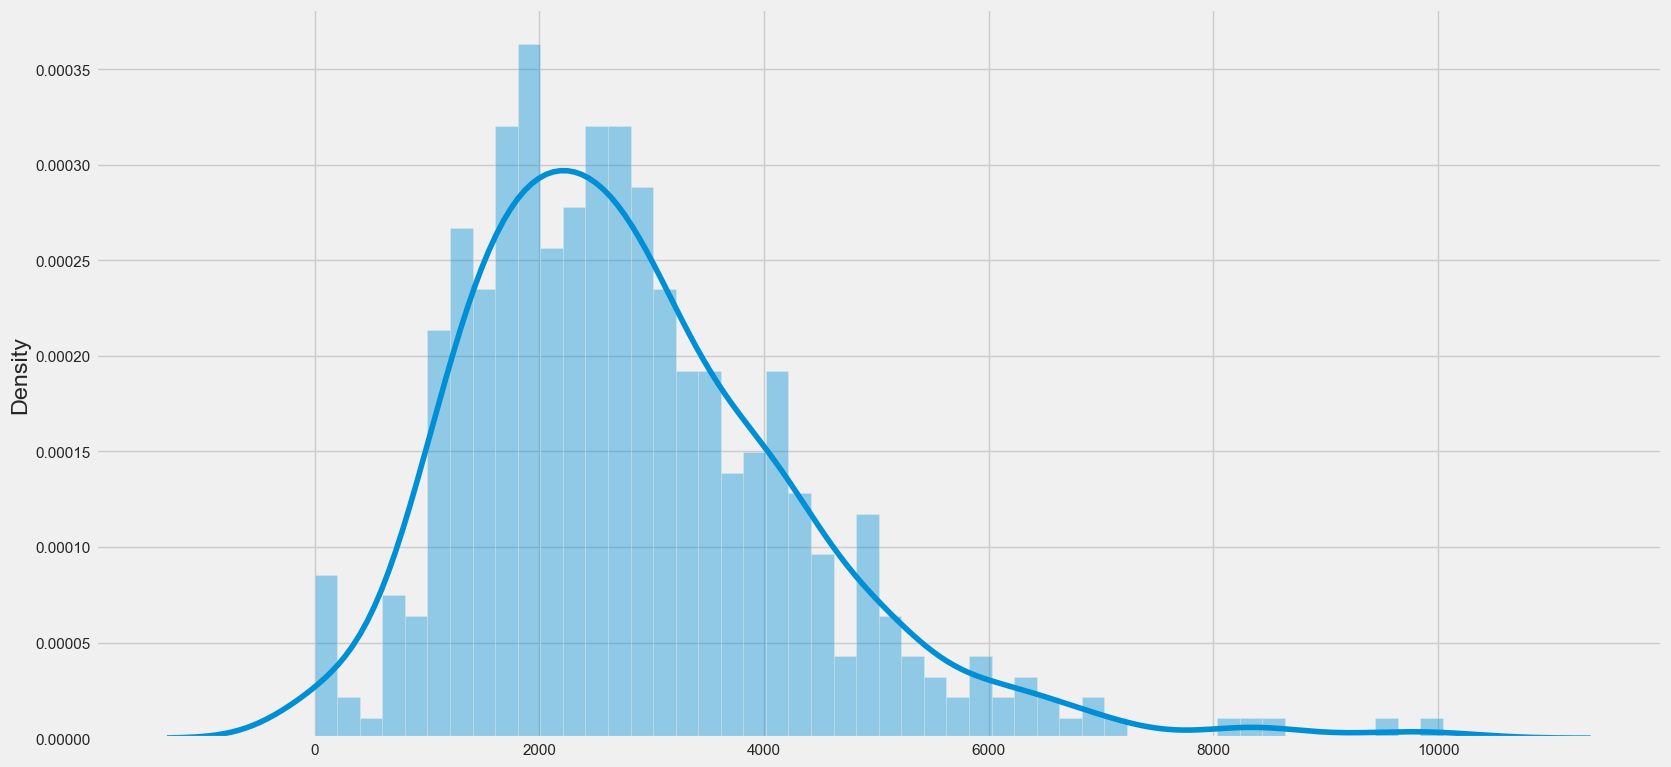

In [118]:
print(proc_testimony_df.shape)
sns.distplot(proc_testimony_df["word_count"].values, bins=50)

In [119]:
# Check records where speaker is null
proc_testimony_df['speaker'].isnull().sum()

0

In [120]:
# Remove sections having less than 50 words because those are unlikely to contain meaningful sentences.
proc_testimony_df = remove_short_section(proc_testimony_df, min_words=50)
proc_testimony_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,<NA>,None,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,<NA>,None,1996-08-20,0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Chairman Alan Greenspan,2966,<NA>,None,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,<NA>,None,1996-08-20,0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Chairman Alan Greenspan,3308,<NA>,None,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
461,testimony,2023-06-21,Nomination hearing,Governor Lisa D. Cook,462,<NA>,None,2023-07-26,1,5.25,"In my work as a Federal Reserve governor, my background and professional experience have prov

In [123]:
# Extract Chairperson's speech
tmp_list = []
for i, row in proc_testimony_df.iterrows():
    chairperson = get_chairperson(row['date'])
    if chairperson:
        last_name_chairperson = chairperson.lower().split()[-1]
        if last_name_chairperson in row['speaker'].lower():
            row['speaker'] = chairperson
    tmp_list.append(list(row))

col_names = proc_testimony_df.columns
testimony_chair_df = pd.DataFrame(data=tmp_list, columns=col_names)
testimony_chair_df

,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",2071,NaN,NaN,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey results h...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-07-17,"""Prime bank"" schemes","Herbert A. Biern, Deputy Associate Director, Division of Banking Supervision and Regulation",959,NaN,NaN,1996-08-20,0,5.25,"I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the problem ...","[, , , , I am pleased to appear before the Committee on Banking, Housing, and Urban Affairs to discuss actions that the Federal Reserve has taken over the past several years to address the...","\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before the Committee on Banking, Housing,\r\n\r\n and Urban Affairs to discuss actions that the Feder..."
2,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,2966,NaN,NaN,1996-08-20,0,5.25,"Before I take this opportunity to discuss the performance of the U.S.economy and the conduct of monetary policy, I would first like to thank theChairman and the other members of this Committee for...","[Testimony of Chairman Alan GreenspanThe Federal Reserve's semiannual monetary policy reportBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate July 18, 1996, Before I take th...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
3,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,2601,NaN,NaN,1996-08-20,0,5.25,I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S. commerci...,"[, , , , I am pleased to appear before this Subcommittee today to discuss trendsin consumer lending and the Federal Reserve Board's view of how recentdevelopments in this sector are affecting U.S....",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
4,testimony,1996-07-26,Recent reports on Federal Reserve operations,Alan Greenspan,3308,NaN,NaN,1996-08-20,0,5.25,"We are strongly committed to ensuring that the Federal Reserve Systemis managed efficiently and effectively. It is most important to us at the FederalReserve Board and the Reserve Banks, not only...","[, , , , I appreciate this opportunity to appear before the Banking Committeetoday to address certain recent reports on the Federal Reserve´s operations. Of mostrelevance, the GAO has raised some...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI appreciate this opportunity to appear before the Banking Committee\r\n\r\ntoday to address certain recent reports on the Feder...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
458,testimony,2023-06-21,Nomination hearing,Governor Lisa D. Cook,462,NaN,NaN,2023-07-26,1,5.25,"In my work as a Federal Reserve governor, my background and professional experience have proven to be invaluable. I spent m

### Split contents to max 200 words

In [124]:
testimony_split_df = get_split_df(testimony_chair_df)
testimony_split_df.reset_index(drop=True, inplace=True)
print(testimony_split_df.shape)
testimony_split_df


(8053, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",200,<NA>,None,1996-07-03,0,5.25,It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve The recent publication of various survey results has focused...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
1,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",200,<NA>,None,1996-07-03,0,5.25,and implementation of an ambitious multi faceted education program for consumers and for banks We also have developed a productive relationship with the NASD that includes the coordination of exam...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
2,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",200,<NA>,None,1996-07-03,0,5.25,about billion of equity and debt funds in up from billion in These uninsured investment products whose prices are most susceptible to changes in interest rates and other market factors generate th...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
3,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",200,<NA>,None,1996-07-03,0,5.25,been required by the Federal Reserve since when it issued interpretations of Regulation Y pertaining to bank holding company sales of uninsured investment instruments such as commercial paper Bank...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
4,testimony,1996-06-26,Supervision of bank sales practices,"Governor Edward W. Kelley, Jr.",200,<NA>,None,1996-07-03,0,5.25,for use in state member banks that sell mutual funds to retail customers The procedures are intended to enhance the supervision of these activities and to assure bank compliance with the guideline...,"[, , , , It is a pleasure to appear before this Subcommittee to discuss the supervision of bank sales practices on behalf of the Federal Reserve. The recent publication of various survey ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt is a pleasure to appear before this Subcommittee to discuss\r\n\r\n the supervision of bank sales practices on behalf of ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,testimony,2023-12-05,Innovation,"Michael S. Gibson, Director, Division of Supervision and Regulation",200,<NA>,None,2023-12-13,0,5.25,to the institutions we supervise We want banks to continue to take advantage of innovations while also operating in a safe an

### Filter out by keyword

In [125]:
# Keep sections having keywords and long enough
testimony_keyword_df = remove_short_nokeyword(testimony_chair_df)
testimony_keyword_df.reset_index(drop=True, inplace=True)
print(testimony_keyword_df.shape)
testimony_keyword_df


(200, 13)


,type,date,title,speaker,word_count,decision,rate,next_meeting,next_decision,next_rate,text,text_sections,org_text
0,testimony,1996-07-18,The Federal Reserve's semiannual monetary report,Alan Greenspan,628,NaN,NaN,1996-08-20,0,5.25,"Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pric...","[Even though the U.S. economy is using its productive resources intensively,inflation has remained quiescent. The core inflation rate, measured by the consumerprice index less food and energy pri...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nJuly 18, 1996\n\n[SECT..."
1,testimony,1996-07-24,Trends in consumer lending,Governor Janet L. Yellen,109,NaN,NaN,1996-08-20,0,5.25,"Nonmortgage consumer debt has grown at double-digit rates over thepast two to three years. This rapid pace is not unusual for a period ofeconomic expansion. Indeed, as the economy emerged from r...","[Nonmortgage consumer debt has grown at double-digit rates over thepast two to three years. This rapid pace is not unusual for a period ofeconomic expansion. Indeed, as the economy emerged from ...",\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nI am pleased to appear before this Subcommittee today to discuss trends\r\n\r\nin consumer lending and the Federal Reserve Board...
2,testimony,1997-01-21,"January 21, 1997",Alan Greenspan,549,NaN,NaN,1997-02-05,0,5.25,"Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","[Mr. Chairman and members of the Committee, I am pleased to appear here today. In just a few weeks the Federal Reserve Board will submit its semiannual report on monetary policy to the Congress. ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nBefore the Committee on the Budget, United States Senate\r\nJanuary 21, 1997\n\n[SECTION]\n\nMr. Chairman and members of th..."
3,testimony,1997-02-26,The Federal Reserve's semiannual monetary policy report,Alan Greenspan,286,NaN,NaN,1997-03-25,1,5.50,"The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy progr...","[The performance of the U.S. economy over the past year has been quite favorable. Real GDP growth picked up to more than three percent over the four quarters of 1996, as the economy prog...","Testimony of Chairman Alan Greenspan\nThe Federal Reserve's semiannual monetary policy report\r\nBefore the Committee on Banking, Housing, and Urban Affairs, U.S. Senate \r\nFebruary 26, 1997\n\n[..."
4,testimony,1997-03-20,Performance of the U.S. economy,Alan Greenspan,160,NaN,NaN,1997-03-25,1,5.50,"Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly i...","[Indeed, the labor markets bear especially careful watching for signs that such a process is under way. So far this year, the demand for labor has stayed strong. Payroll employment grew briskly ...","Testimony of Chairman Alan Greenspan\nPerformance of the U.S. economy\r\nJoint Economic Committee, United States Congress\r\n\r\nMarch 20, 1997\n\n[SECTION]\n\n\n\n[SECTION]\n\nMr. Chairman and me..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,testimony,2023-03-07,Semiannual Monetary Policy Report to the Congress,Chair Jerome H. Powell,376,NaN,NaN,2023-03-22,1,4.75,"Turning to growth, the U.S. economy slowed significantly last year, with real gross domestic product rising at a below-trend pace of 0.9 percent. Although consumer spending

In [126]:
# Drop text sections
testimony_chair_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_split_df.drop(columns=['text_sections', 'org_text'], inplace=True)
testimony_keyword_df.drop(columns=['text_sections', 'org_text'], inplace=True)

## Save the train data

In [127]:
# Combine dataframes
text_no_split = pd.concat([proc_statement_df, 
                           proc_minutes_df, 
                           presconf_script_chair_day_df, 
                           meeting_script_speaker_df, 
                           speech_chair_df,
                           testimony_chair_df], sort=False)
text_no_split.reset_index(drop=True, inplace=True)

text_split_200 = pd.concat([split_statement_df, 
                            split_minutes_df, 
                            presconf_script_split_df, 
                            meeting_script_split_df, 
                            speech_split_df, 
                            testimony_split_df], sort=False)
text_split_200.reset_index(drop=True, inplace=True)

text_keyword = pd.concat([keyword_statement_df,
                          keyword_minutes_df,
                          presconf_script_keyword_df,
                          meeting_script_keyword_df, 
                          speech_keyword_df, 
                          testimony_keyword_df], sort=False)
text_keyword.reset_index(drop=True, inplace=True)

C:\Users\luisl\AppData\Local\Temp\ipykernel_19908\3035175076.py:2: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  text_no_split = pd.concat([proc_statement_df,
C:\Users\luisl\AppData\Local\Temp\ipykernel_19908\3035175076.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  text_split_200 = pd.concat([split_statement_df,
C:\Users\luisl\AppData\Local\Temp\ipykernel_19908\3035175076.py:18: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future 

In [128]:
def save_data(df, file_name, dir_name='../data/preprocessed/'):
    '''
    Save the given df to pickle file and csv file in the given directory.
    '''
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)
    
    # Save results to a picke file
    file = open(dir_name + file_name + '.pickle', 'wb')
    pickle.dump(df, file)
    file.close()
    print("Data Saved to a pickle file in {} !".format(dir_name))

    # Save results to a csv file
    df.to_csv(dir_name + file_name + '.csv', index=True)
    print("Data Saved to a csv file in {} !".format(dir_name))
    

In [129]:
save_data(text_no_split, 'text_no_split')
save_data(text_split_200, 'text_split_200')
save_data(text_keyword, 'text_keyword')

Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
Data Saved to a pickle file in ../data/preprocessed/ !
Data Saved to a csv file in ../data/preprocessed/ !
